# Machine Learning Project - IA mention CentraleSupélec

Under the supervision of :

- Myriam TAMI

Students:

- Lucas Tramonte

# Libraries


In [218]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

from sklearn.feature_selection import f_regression, SelectKBest, RFECV


# EDA

In [219]:
data_original = pd.read_csv('Assets/Data/welddb.data', delimiter='\s+', header=None)

In [220]:
data = data_original.copy()

# Name the columns
data.columns = [
    'Carbon concentration (weight%)', 
    'Silicon concentration (weight%)', 
    'Manganese concentration (weight%)', 
    'Sulphur concentration (weight%)', 
    'Phosphorus concentration (weight%)', 
    'Nickel concentration (weight%)', 
    'Chromium concentration (weight%)', 
    'Molybdenum concentration (weight%)', 
    'Vanadium concentration (weight%)', 
    'Copper concentration (weight%)', 
    'Cobalt concentration (weight%)', 
    'Tungsten concentration (weight%)', 
    'Oxygen concentration (ppm by weight)', 
    'Titanium concentration (ppm by weight)', 
    'Nitrogen concentration (ppm by weight)', 
    'Aluminium concentration (ppm by weight)', 
    'Boron concentration (ppm by weight)', 
    'Niobium concentration (ppm by weight)', 
    'Tin concentration (ppm by weight)', 
    'Arsenic concentration (ppm by weight)', 
    'Antimony concentration (ppm by weight)', 
    'Current (A)', 
    'Voltage (V)', 
    'AC or DC', 
    'Electrode positive or negative', 
    'Heat input (kJ/mm)', 
    'Interpass temperature (°C)', 
    'Type of weld', 
    'Post weld heat treatment temperature (°C)', 
    'Post weld heat treatment time (hours)', 
    'Yield strength (MPa)', 
    'Ultimate tensile strength (MPa)', 
    'Elongation (%)', 
    'Reduction of Area (%)', 
    'Charpy temperature (°C)', 
    'Charpy impact toughness (J)', 
    'Hardness (kg/mm2)', 
    '50% FATT', 
    'Primary ferrite in microstructure (%)', 
    'Ferrite with second phase (%)', 
    'Acicular ferrite (%)', 
    'Martensite (%)', 
    'Ferrite with carbide aggregate (%)', 
    'Weld ID'
]

data

,Carbon concentration (weight%),Silicon concentration (weight%),Manganese concentration (weight%),Sulphur concentration (weight%),Phosphorus concentration (weight%),Nickel concentration (weight%),Chromium concentration (weight%),Molybdenum concentration (weight%),Vanadium concentration (weight%),Copper concentration (weight%),...,Charpy temperature (°C),Charpy impact toughness (J),Hardness (kg/mm2),50% FATT,Primary ferrite in microstructure (%),Ferrite with second phase (%),Acicular ferrite (%),Martensite (%),Ferrite with carbide aggregate (%),Weld ID
0,0.037,0.30,0.65,0.008,0.012,0,N,N,N,N,...,N,N,N,N,N,N,N,N,N,Evans-Ni/CMn-1990/1991-0Aaw
1,0.037,0.30,0.65,0.008,0.012,0,N,N,N,N,...,-28,100,N,N,N,N,N,N,N,Evans-Ni/CMn-1990/1991-0Aawch
2,0.037,0.30,0.65,0.008,0.012,0,N,N,N,N,...,-38,100,N,N,N,N,N,N,N,Evans-Ni/CMn-1990/1991-0Aht
3,0.037,0.31,1.03,0.007,0.014,0,N,N,N,N,...,N,N,N,N,N,N,N,N,N,Evans-Ni/CMn-1990/1991-0Baw
4,0.037,0.31,1.03,0.007,0.014,0,N,N,N,N,...,-48,100,N,N,32,28,40,0,0,Evans-Ni/CMn-1990/1991-0Bawch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,N,...,N,N,N,N,N,N,N,N,N,Birmingham-MAX35
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,N,...,N,N,N,N,N,N,N,N,N,Birmingham-MAX36
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,N,...,N,N,N,N,N,N,N,N,N,Birmingham-MAX37
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,N,...,N,N,N,N,N,N,N,N,N,Birmingham-MAX38


Percentage of 'N' values in each column

In [221]:
percent_n = (data == 'N').mean() * 100
percent_n_sorted = percent_n.sort_values(ascending=False).apply(lambda x: f"{x:.2f}%")
percent_n_sorted

50% FATT                                     98.12%
Tungsten concentration (weight%)             95.46%
Ferrite with carbide aggregate (%)           94.61%
Martensite (%)                               94.61%
Ferrite with second phase (%)                94.55%
Acicular ferrite (%)                         94.55%
Primary ferrite in microstructure (%)        94.07%
Cobalt concentration (weight%)               92.19%
Hardness (kg/mm2)                            91.65%
Arsenic concentration (ppm by weight)        85.84%
Antimony concentration (ppm by weight)       84.26%
Tin concentration (ppm by weight)            82.08%
Boron concentration (ppm by weight)          69.49%
Copper concentration (weight%)               65.01%
Nickel concentration (weight%)               57.81%
Elongation (%)                               57.63%
Reduction of Area (%)                        57.32%
Ultimate tensile strength (MPa)              55.33%
Niobium concentration (ppm by weight)        54.48%
Yield streng

- The presence of an ``N'' indicates that the value was not reported in the publication. This is NOT meant to be an indication that the value is zero.

- It wouldn't make sense to set the phosphorus and sulfur concentrations to zero when their values aren't reported, because these impurity elements are inevitably present in welds in practice. 
    -   Therefore, we'll use the average values for these concentrations in such cases. 
    -   On the other hand, for other elements like manganese and nickel, it is reasonable to set their concentrations to zero if they are not reported. This is because they wouldn't be deliberate additions and their concentrations would be close to the detection limits of the commonly used analytical techniques [1].

In [222]:
# Replace 'N' with NaN
data.replace('N', pd.NA, inplace=True)

categoric_features = ['AC or DC', 'Electrode positive or negative','Type of weld'] # Weld ID isn't important
data_categoric = data[categoric_features] 

# Convert columns to numeric 
numeric_features = data.drop(columns = ['Weld ID','AC or DC', 'Electrode positive or negative','Type of weld']).columns
data_numeric = data[numeric_features].apply(pd.to_numeric, errors='coerce')

mean_phosphorus = data_numeric['Phosphorus concentration (weight%)'].dropna().astype(float).mean()
mean_sulphur = data_numeric['Sulphur concentration (weight%)'].dropna().astype(float).mean()

# Replace NaNs with average values for Phosphorus and Sulphur
data_numeric['Phosphorus concentration (weight%)'] = data_numeric['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)
data_numeric['Sulphur concentration (weight%)'] = data_numeric['Sulphur concentration (weight%)'].fillna(mean_sulphur)

# Replace NaNs with 0 for the other columns
data_numeric = data_numeric.fillna(0)
data_categoric = data_categoric.fillna(0)

data_categoric["Electrode positive or negative"] = data_categoric["Electrode positive or negative"].replace([0, '0'], '0')
data_categoric["Electrode positive or negative"] = data_categoric["Electrode positive or negative"].astype("category")

# Concatenate dataframes

data_all = pd.concat([data_numeric, data_categoric], axis = 1)

Numeric features

In [223]:
# We need to remove the Charpy temperature (°C) and 50% FATT features
print("------------# of negative values : ------------ \n ")
print((data_numeric < 0).sum())

------------# of negative values : ------------ 
 
Carbon concentration (weight%)                 0
Silicon concentration (weight%)                0
Manganese concentration (weight%)              0
Sulphur concentration (weight%)                0
Phosphorus concentration (weight%)             0
Nickel concentration (weight%)                 0
Chromium concentration (weight%)               0
Molybdenum concentration (weight%)             0
Vanadium concentration (weight%)               0
Copper concentration (weight%)                 0
Cobalt concentration (weight%)                 0
Tungsten concentration (weight%)               0
Oxygen concentration (ppm by weight)           0
Titanium concentration (ppm by weight)         0
Nitrogen concentration (ppm by weight)         0
Aluminium concentration (ppm by weight)        0
Boron concentration (ppm by weight)            0
Niobium concentration (ppm by weight)          0
Tin concentration (ppm by weight)              0
Arsenic concentrat

In [224]:
data_numeric.drop(columns = ["Charpy temperature (°C)", "50% FATT"], inplace = True)
data_numeric = data_numeric.drop_duplicates(keep='last') #9 duplicated rows

data_all.drop(columns = ["Charpy temperature (°C)", "50% FATT"], inplace = True)
data_all = data_all.drop_duplicates(keep='last') #9 duplicated rows

# Reorder columns for better visualization
cols = data_numeric.columns.tolist()
cols.remove('Yield strength (MPa)')
cols.remove('Ultimate tensile strength (MPa)')

cols.append('Ultimate tensile strength (MPa)')
cols.append('Yield strength (MPa)')

data_numeric = data_numeric[cols]

# Summary
summary = pd.DataFrame({
    'Variable': data_numeric.columns,
    'Min': [data_numeric[col].min() for col in data_numeric.columns],
    'Max': [data_numeric[col].max() for col in data_numeric.columns],
    'Mean': [data_numeric[col].mean() for col in data_numeric.columns],
    'Standard Deviation': [data_numeric[col].std() for col in data_numeric.columns]
})

summary

,Variable,Min,Max,Mean,Standard Deviation
0,Carbon concentration (weight%),0.029,0.18,0.075806,0.023817
1,Silicon concentration (weight%),0.040,1.14,0.329785,0.112267
2,Manganese concentration (weight%),0.270,2.25,1.205151,0.382377
3,Sulphur concentration (weight%),0.001,0.14,0.009498,0.010814
4,Phosphorus concentration (weight%),0.002,0.25,0.012819,0.018822
5,Nickel concentration (weight%),0.000,3.50,0.176590,0.554808
6,Chromium concentration (weight%),0.000,10.20,0.996368,2.348730
7,Molybdenum concentration (weight%),0.000,1.50,0.225411,0.404342
8,Vanadium concentration (weight%),0.000,0.32,0.027266,0.068794
9,Copper concentration (weight%),0.000,1.63,0.061126,0.209431


array([[<Axes: title={'center': 'Carbon concentration (weight%)'}>,
        <Axes: title={'center': 'Silicon concentration (weight%)'}>,
        <Axes: title={'center': 'Manganese concentration (weight%)'}>,
        <Axes: title={'center': 'Sulphur concentration (weight%)'}>,
        <Axes: title={'center': 'Phosphorus concentration (weight%)'}>,
        <Axes: title={'center': 'Nickel concentration (weight%)'}>],
       [<Axes: title={'center': 'Chromium concentration (weight%)'}>,
        <Axes: title={'center': 'Molybdenum concentration (weight%)'}>,
        <Axes: title={'center': 'Vanadium concentration (weight%)'}>,
        <Axes: title={'center': 'Copper concentration (weight%)'}>,
        <Axes: title={'center': 'Cobalt concentration (weight%)'}>,
        <Axes: title={'center': 'Tungsten concentration (weight%)'}>],
       [<Axes: title={'center': 'Oxygen concentration (ppm by weight)'}>,
        <Axes: title={'center': 'Titanium concentration (ppm by weight)'}>,
        <Axes

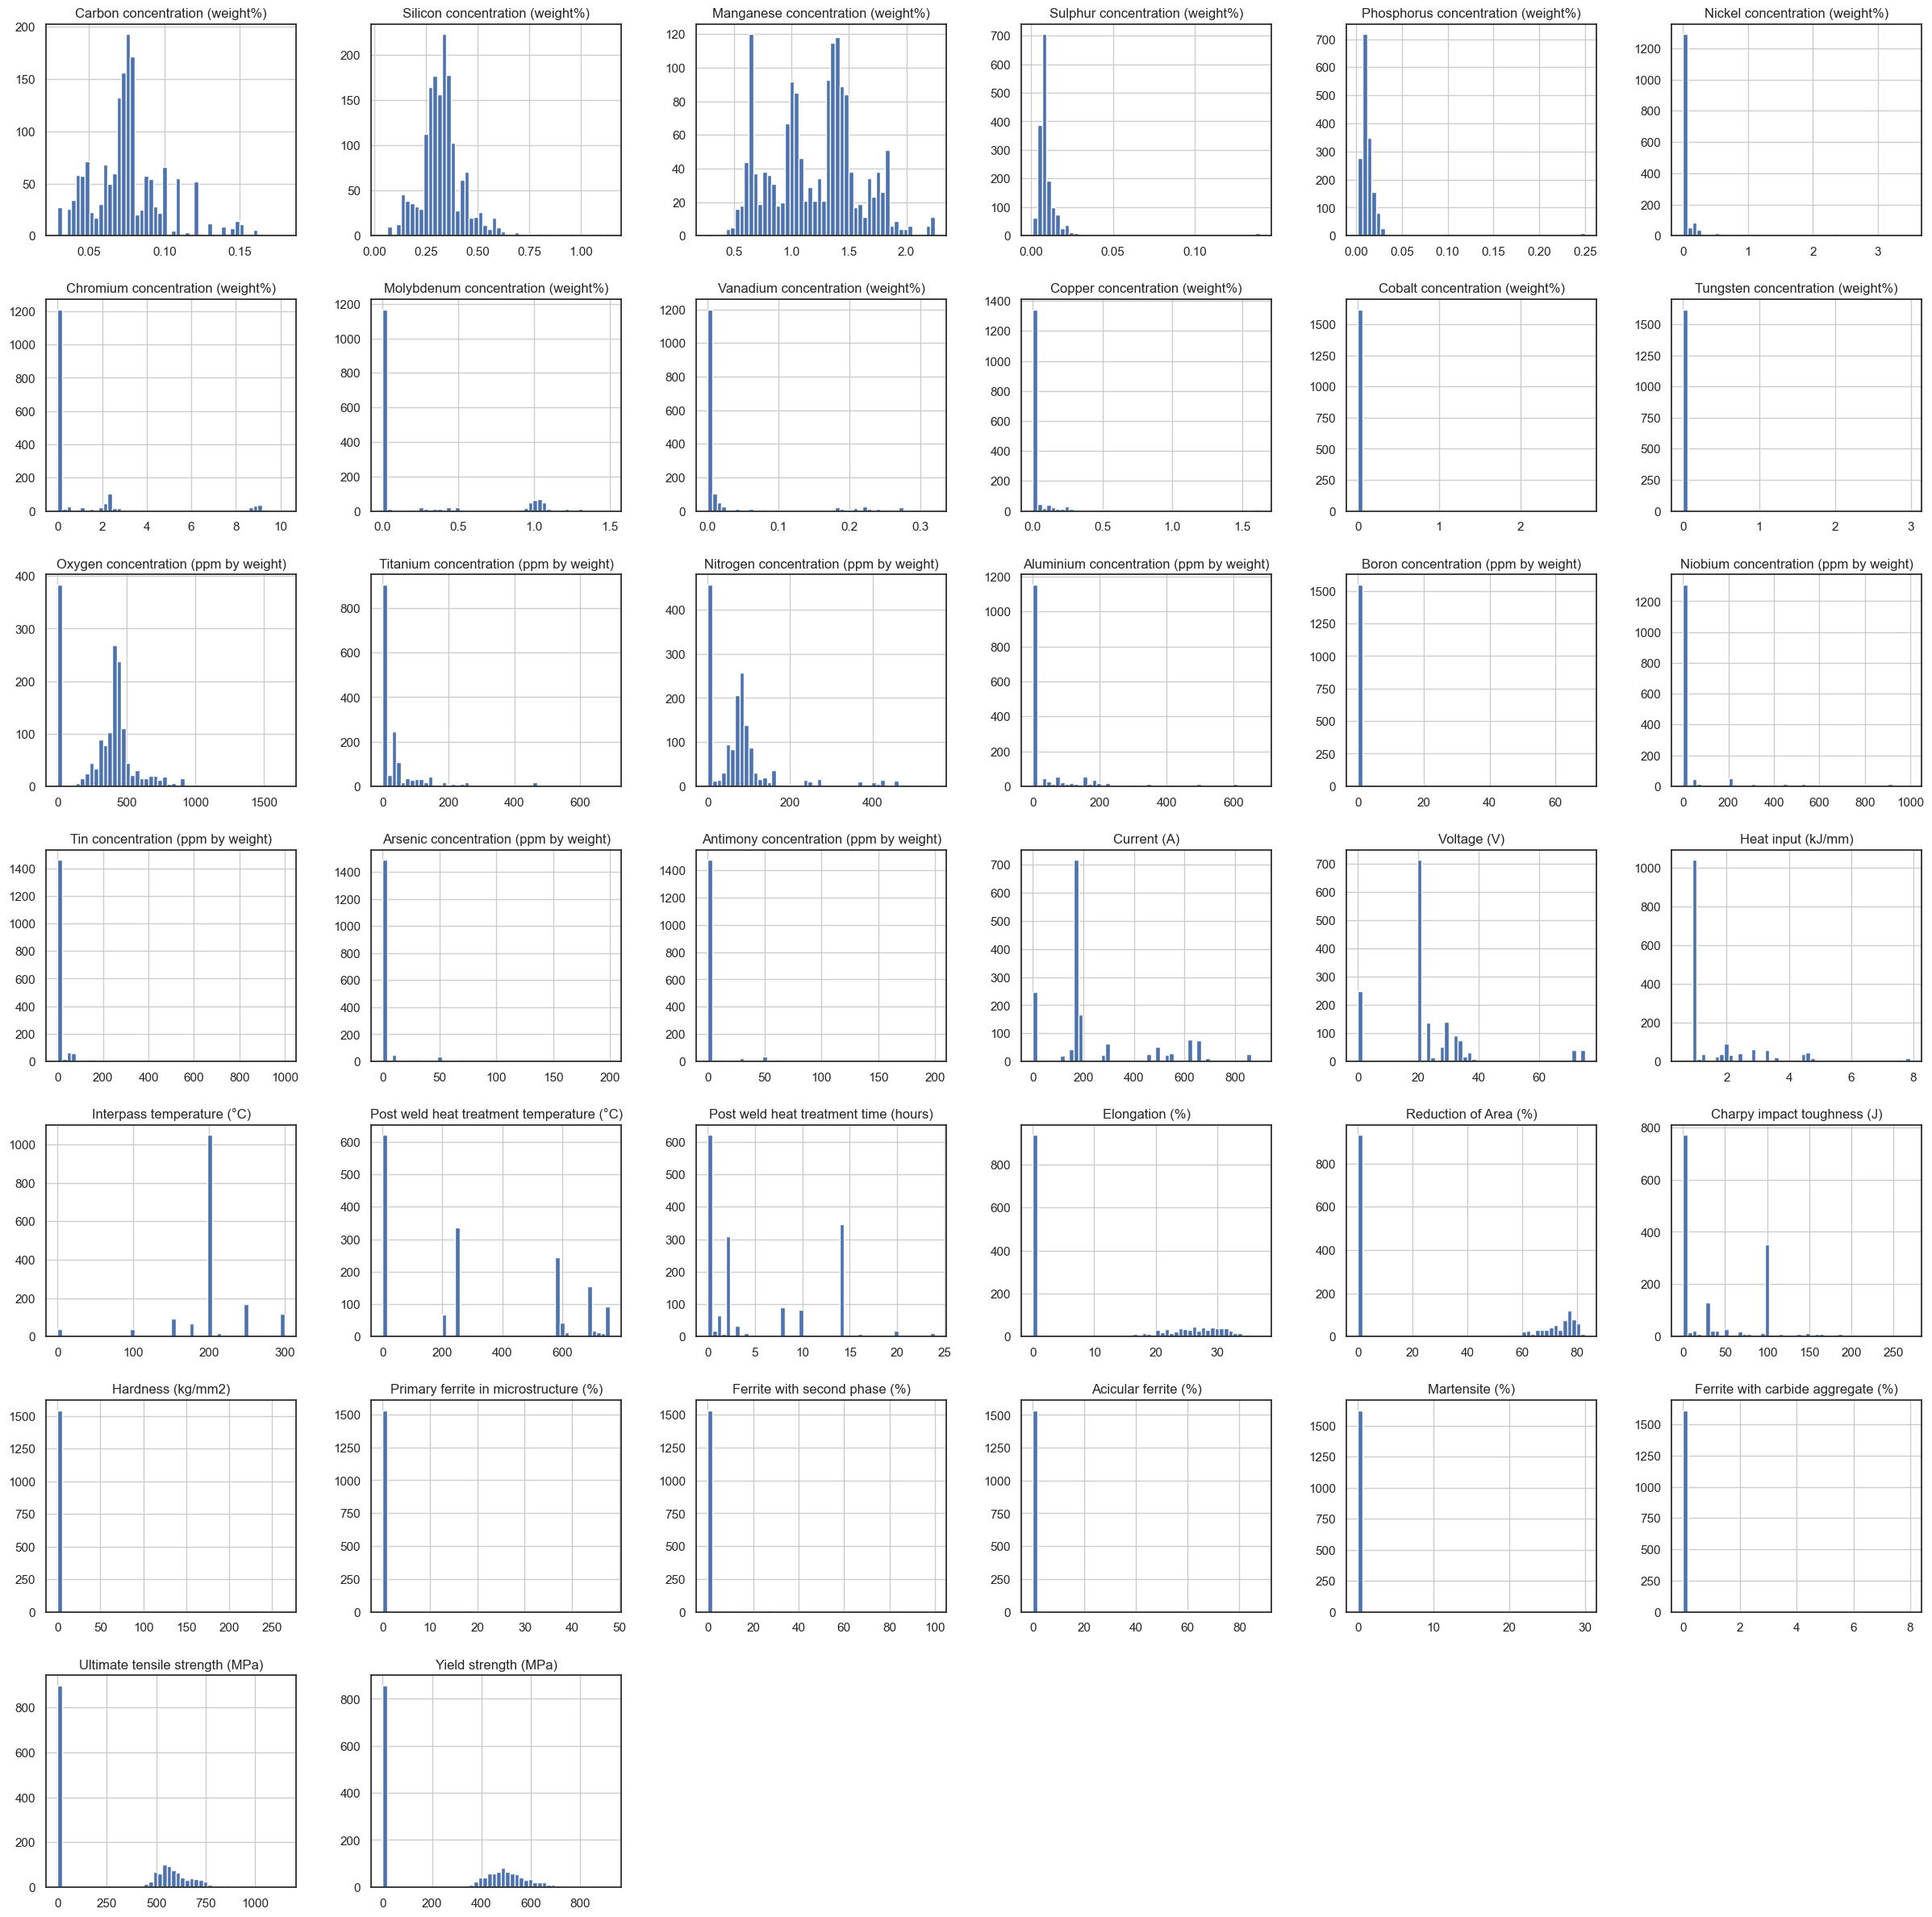

In [225]:
data_numeric.hist(bins = 50, figsize= (30,30))

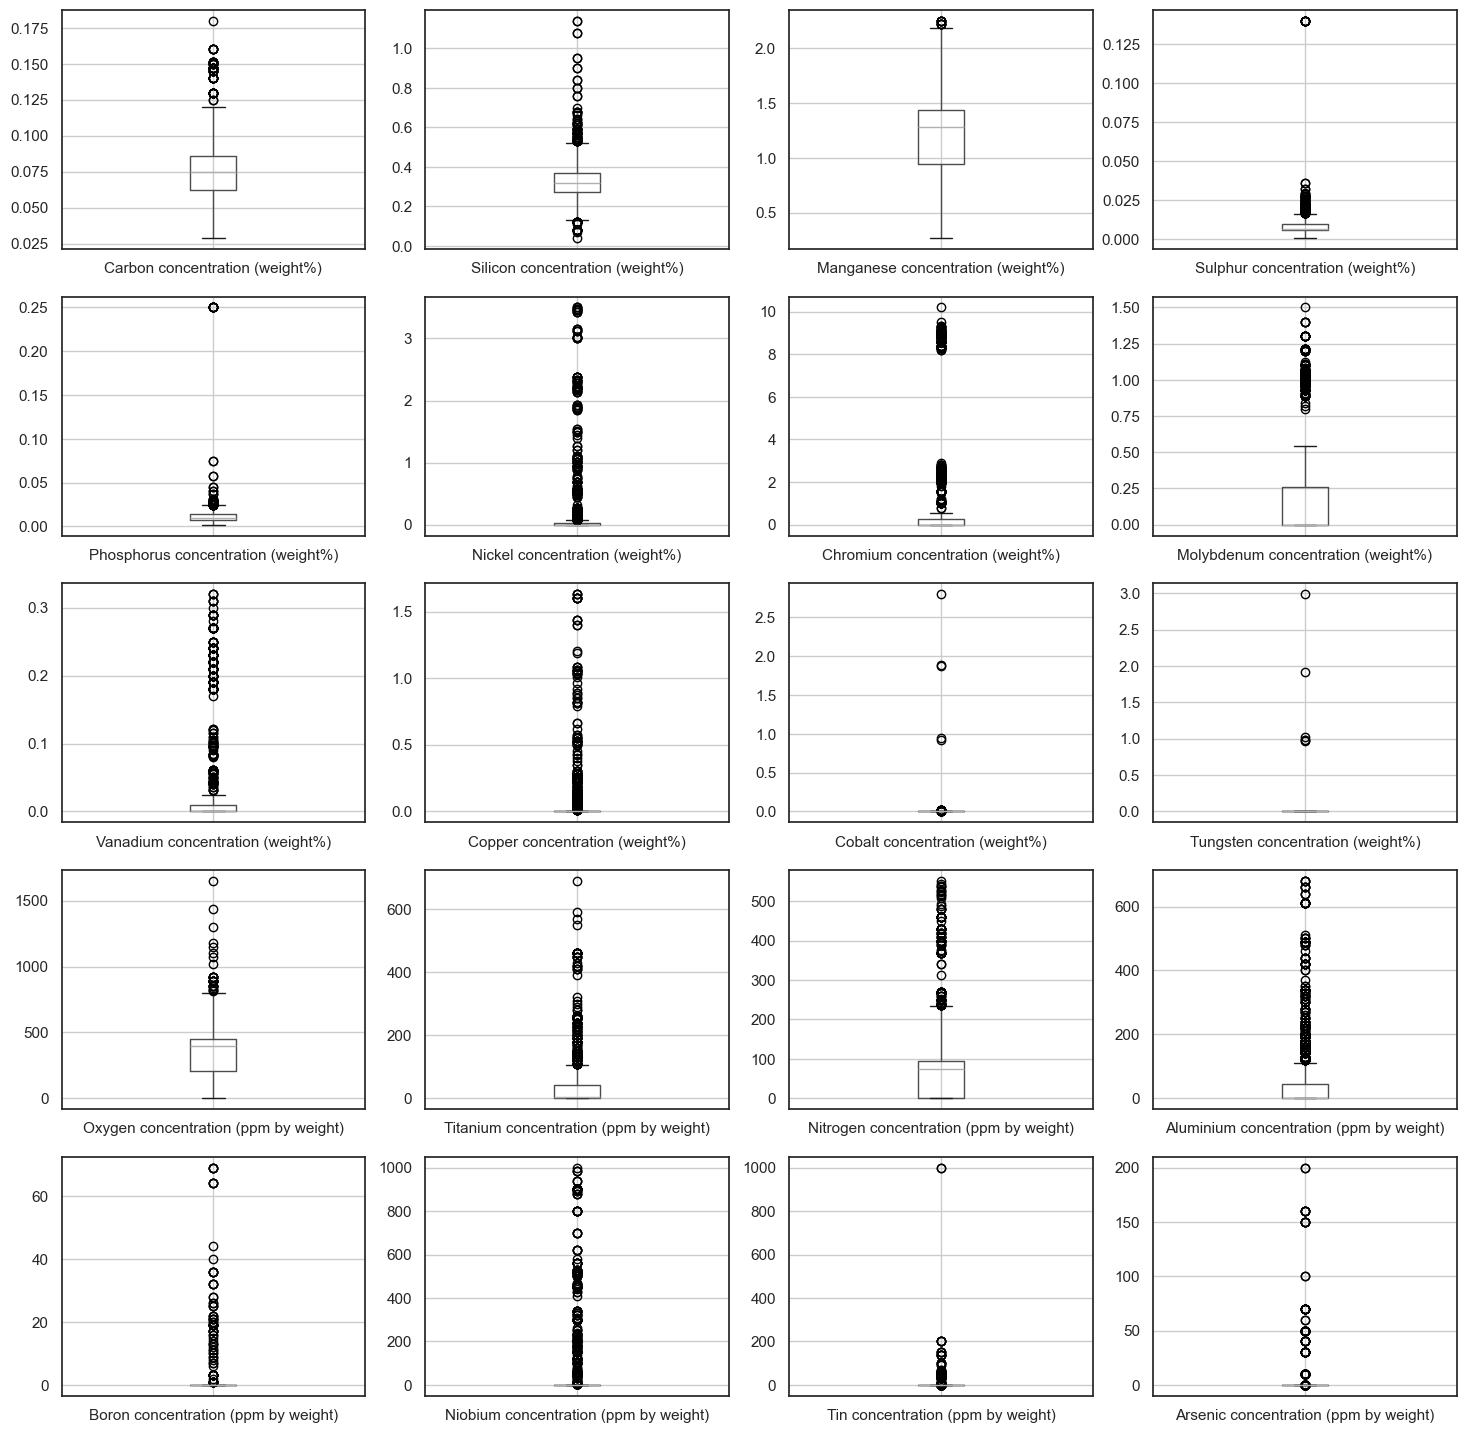

In [226]:
fig, axs = plt.subplots(5,4, figsize = (18,18))

for ax, col in zip(axs.flatten(), data_numeric.iloc[:,0:20].columns):
    data_numeric.iloc[:,0:20].boxplot(column = col, ax = ax)

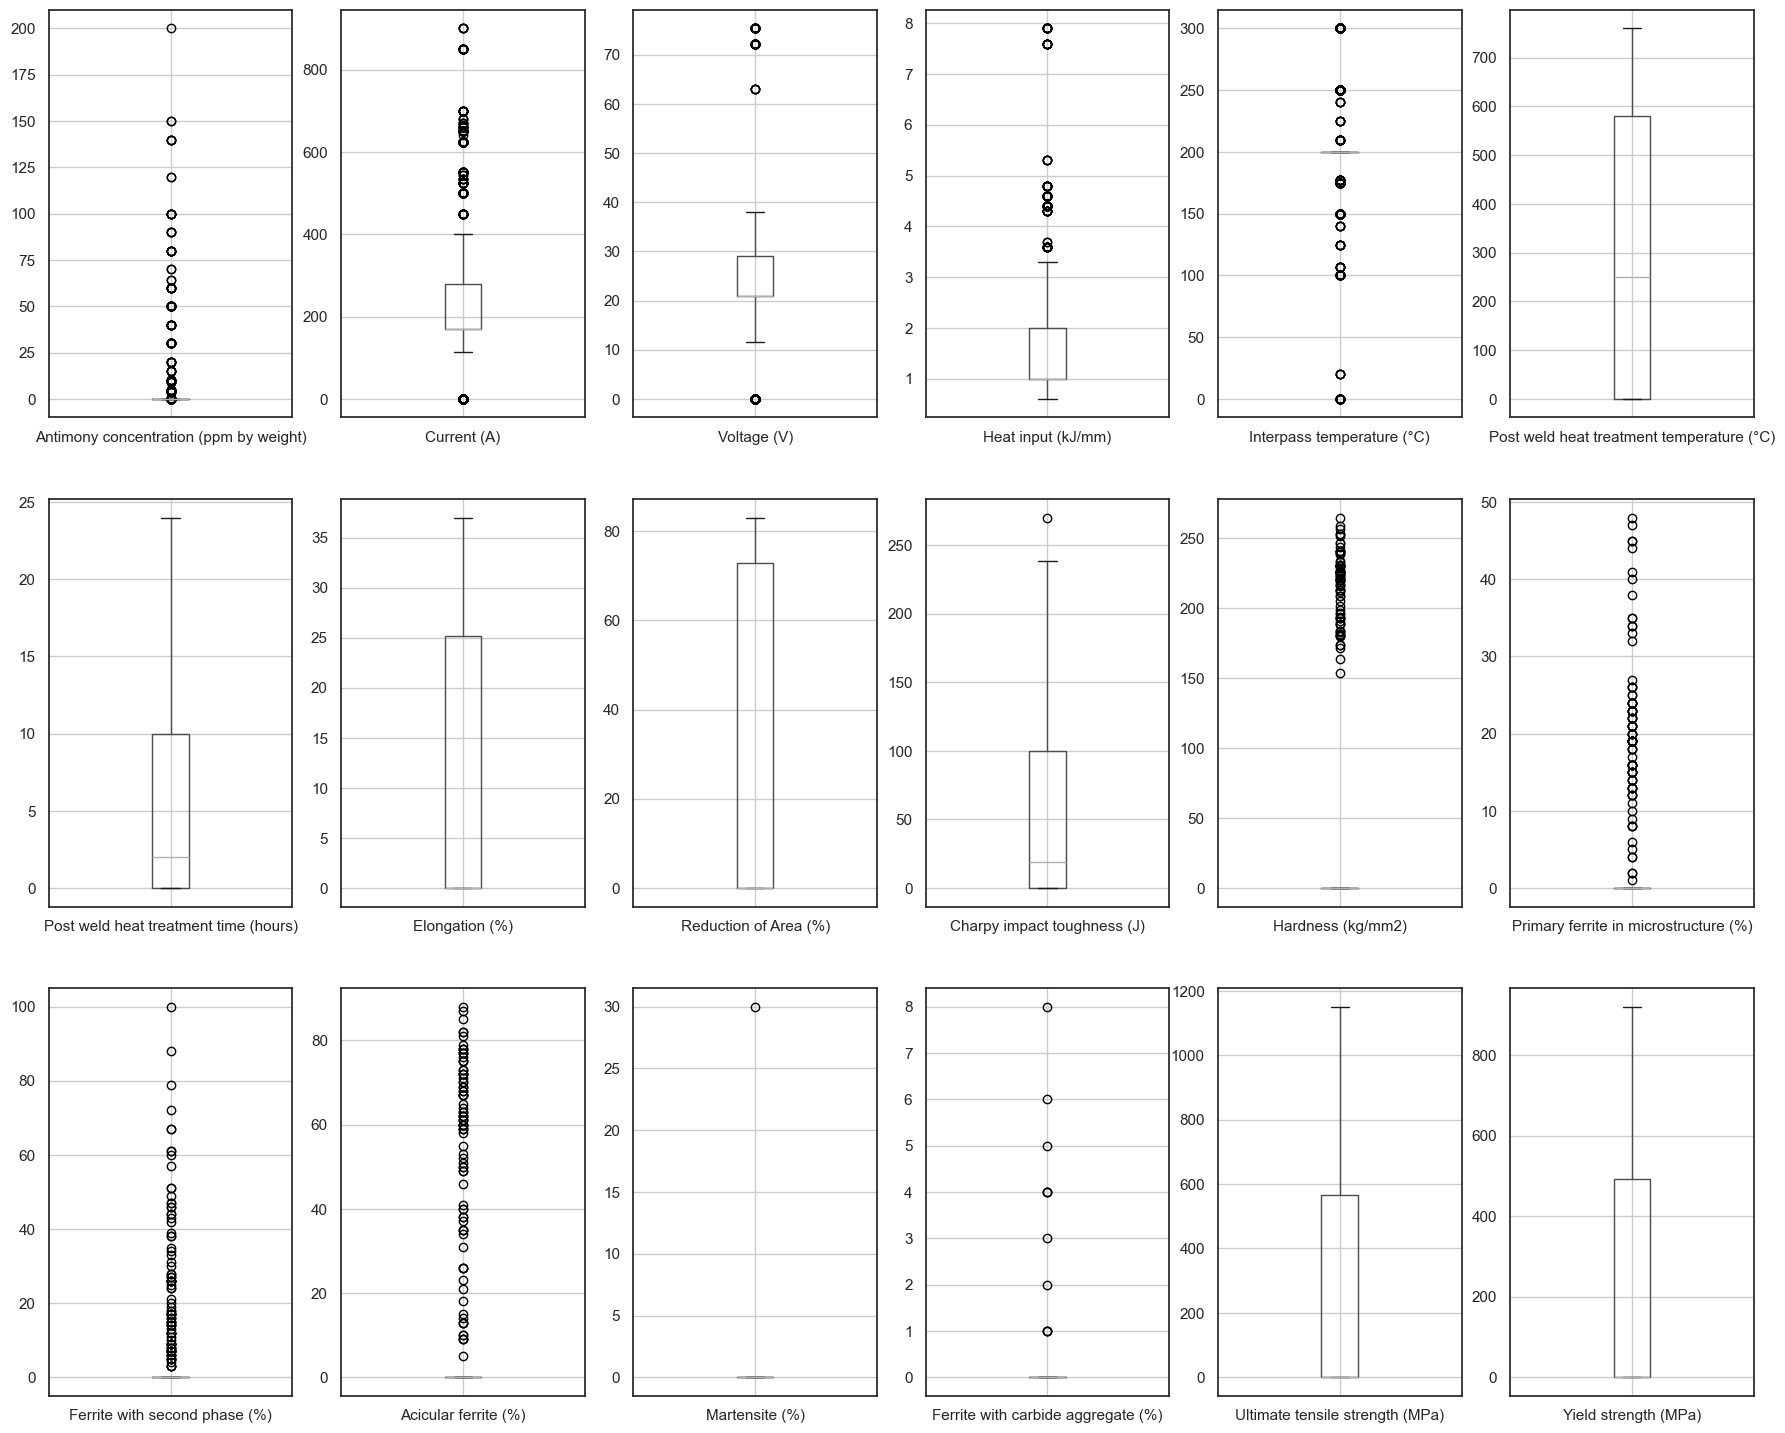

In [227]:
fig, axs = plt.subplots(3,6, figsize = (22,18))

for ax, col in zip(axs.flatten(), data_numeric.iloc[:,20::].columns):
    data_numeric.iloc[:,20::].boxplot(column = col, ax = ax)

In [228]:
data_numeric.corr().style.background_gradient(cmap="coolwarm")

,Carbon concentration (weight%),Silicon concentration (weight%),Manganese concentration (weight%),Sulphur concentration (weight%),Phosphorus concentration (weight%),Nickel concentration (weight%),Chromium concentration (weight%),Molybdenum concentration (weight%),Vanadium concentration (weight%),Copper concentration (weight%),Cobalt concentration (weight%),Tungsten concentration (weight%),Oxygen concentration (ppm by weight),Titanium concentration (ppm by weight),Nitrogen concentration (ppm by weight),Aluminium concentration (ppm by weight),Boron concentration (ppm by weight),Niobium concentration (ppm by weight),Tin concentration (ppm by weight),Arsenic concentration (ppm by weight),Antimony concentration (ppm by weight),Current (A),Voltage (V),Heat input (kJ/mm),Interpass temperature (°C),Post weld heat treatment temperature (°C),Post weld heat treatment time (hours),Elongation (%),Reduction of Area (%),Charpy impact toughness (J),Hardness (kg/mm2),Primary ferrite in microstructure (%),Ferrite with second phase (%),Acicular ferrite (%),Martensite (%),Ferrite with carbide aggregate (%),Ultimate tensile strength (MPa),Yield strength (MPa)
Carbon concentration (weight%),1.000000,-0.099714,0.062329,0.033805,-0.004970,-0.188616,0.163612,0.144165,0.310152,-0.039956,0.037175,0.041645,-0.031164,-0.025244,0.147278,0.061749,0.034775,0.205194,0.061085,0.102167,0.064337,0.350131,0.205033,0.285685,0.182584,0.101021,-0.091282,-0.040365,-0.034002,-0.069770,-0.051766,-0.050438,-0.070358,-0.079233,-0.025853,-0.001554,-0.034032,0.004934
Silicon concentration (weight%),-0.099714,1.000000,0.192875,-0.050421,-0.039185,-0.075037,-0.161979,-0.279516,-0.213270,-0.069451,-0.072883,-0.067477,0.037882,0.310809,-0.142186,0.485025,-0.055368,-0.096155,0.029494,0.005938,0.031901,-0.038148,-0.078607,-0.112148,0.081173,-0.204592,-0.212653,0.044729,0.006886,-0.108412,0.009270,0.065659,0.036235,0.069191,0.006681,0.009322,0.075982,0.066819
Manganese concentration (weight%),0.062329,0.192875,1.000000,0.016231,0.038222,-0.081809,-0.269868,-0.324894,-0.158310,-0.038546,-0.031869,-0.027908,-0.056055,0.185654,-0.089459,0.124313,-0.027255,-0.115075,0.023606,0.017460,0.103553,0.101553,0.133076,0.084674,0.074824,-0.315793,-0.218663,0.007706,0.008505,-0.012329,-0.158325,-0.017616,-0.036479,0.074221,0.037966,-0.048415,0.015962,0.049935
Sulphur concentration (weight%),0.033805,-0.050421,0.016231,1.000000,0.936083,-0.009240,-0.022577,0.153164,0.073520,0.016398,-0.009204,-0.009144,0.065652,-0.074672,0.101844,-0.044419,-0.016150,-0.073302,0.032118,-0.002009,0.046647,0.203146,0.209567,0.245946,0.046168,0.049736,-0.025137,-0.003235,-0.013894,-0.057578,0.108261,-0.067606,-0.050559,-0.067826,-0.005734,-0.015129,0.028289,0.037769
Phosphorus concentration (weight%),-0.004970,-0.039185,0.038222,0.936083,1.000000,0.016639,0.036049,0.165552,0.147510,0.002188,0.006210,0.006278,0.010494,-0.088119,0.156748,-0.009067,0.001714,-0.034572,0.092132,0.008535,0.075921,0.146479,0.144927,0.178785,-0.033897,0.069634,-0.018022,-0.001680,-0.016387,-0.070551,0.093571,-0.056735,-0.043115,-0.054303,0.000238,-0.024607,0.010161,0.038791
Nickel concentration (weight%),-0.188616,-0.075037,-0.081809,-0.009240,0.016639,1.000000,0.025912,-0.001791,0.007595,0.070201,-0.016196,-0.007211,-0.079894,-0.058641,-0.012072,-0.078925,0.027770,-0.001095,-0.044516,-0.046416,-0.050083,-0.071898,-0.113613,-0.031914,-0.122044,0.003265,0.091337,0.031675,0.003748,-0.050918,0.052648,-0.039024,0.006322,-0.005339,0.145111,-0.022462,0.071558,0.110972
Chromium concentration (weight%),0.163612,-0.161979,-0.269868,-0.022577,0.036049,0.025912,1.000000,0.721542,0.803365,-0.086342,0.190323,0.189458,0.207425,-0.201287,0.714314,-0.157125,0.302847,0.622717,-0.049227,0.006992,-0.101769,-0.017729,0.097325,-0.089316,-0.399025,0.530248,0.128727,-0.164298,-0.143011,-0.133324,0.011208,-0.077975,-0.061432,-0.087732,-0.010530,-0.029937,-0.067729,-0.050088
Molybdenum concentration (weight%),0.144165,-0.279516,-0.324894,0.153164,0.165552,-0.00179

- Sulphur concentration and Phosphorus concentration are highly correlated, then we must keep only one of them.
- Chromium, Molybdenum and Vanadium concentration are highly correlated, then we must keep only one of them.
- Elongation (%) and Reduction of Area (%) are highly correlated, then we must keep only one of them.
- Reduction of Area (%) are highly correlated with the target variables Yield strenght and Ultimate tensile strenght, then we must keep it on the prediction!!
- Yield strenght and Ultimate tensile strenght are highly correlated, then we should keep the Yield strenght on the prediction of the Ultimate tensile strenght !!

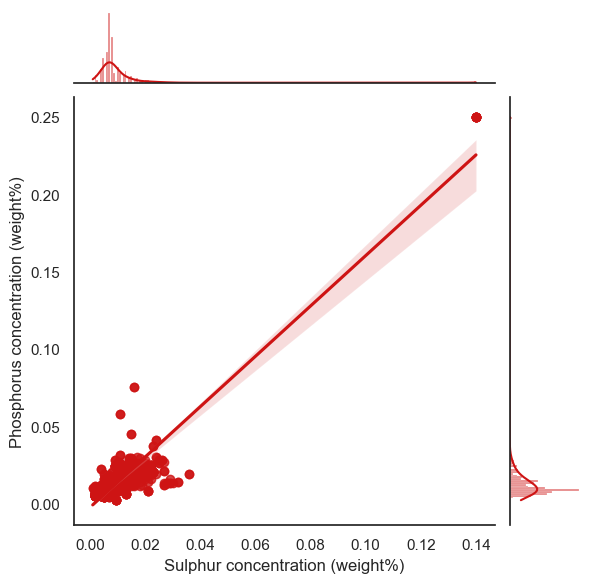

In [229]:
sns.jointplot(data = data_numeric, x = "Sulphur concentration (weight%)",y = "Phosphorus concentration (weight%)", kind="reg", color="#ce1414")

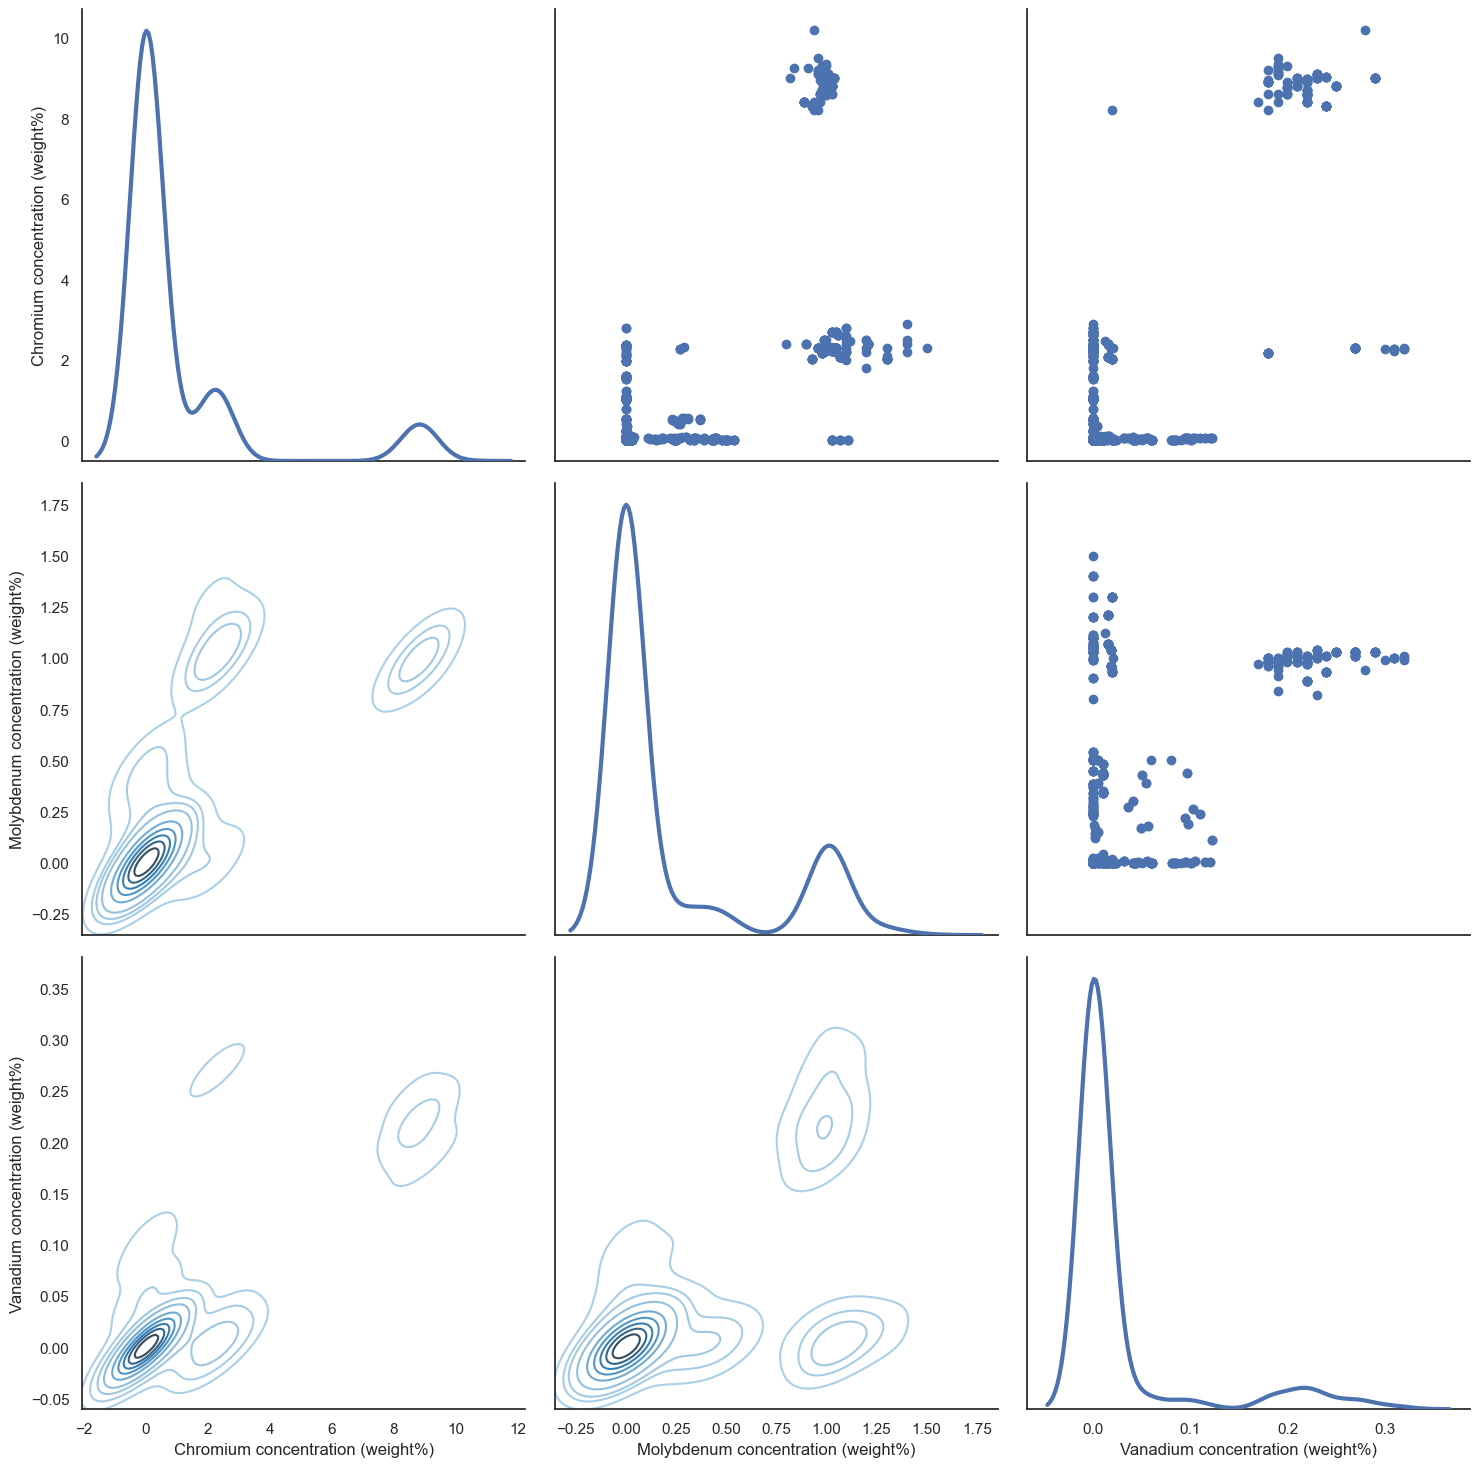

In [230]:
sns.set(style="white")
g = sns.PairGrid(data_numeric.loc[:,['Chromium concentration (weight%)','Molybdenum concentration (weight%)','Vanadium concentration (weight%)']], diag_sharey=False, height=5, aspect=1)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

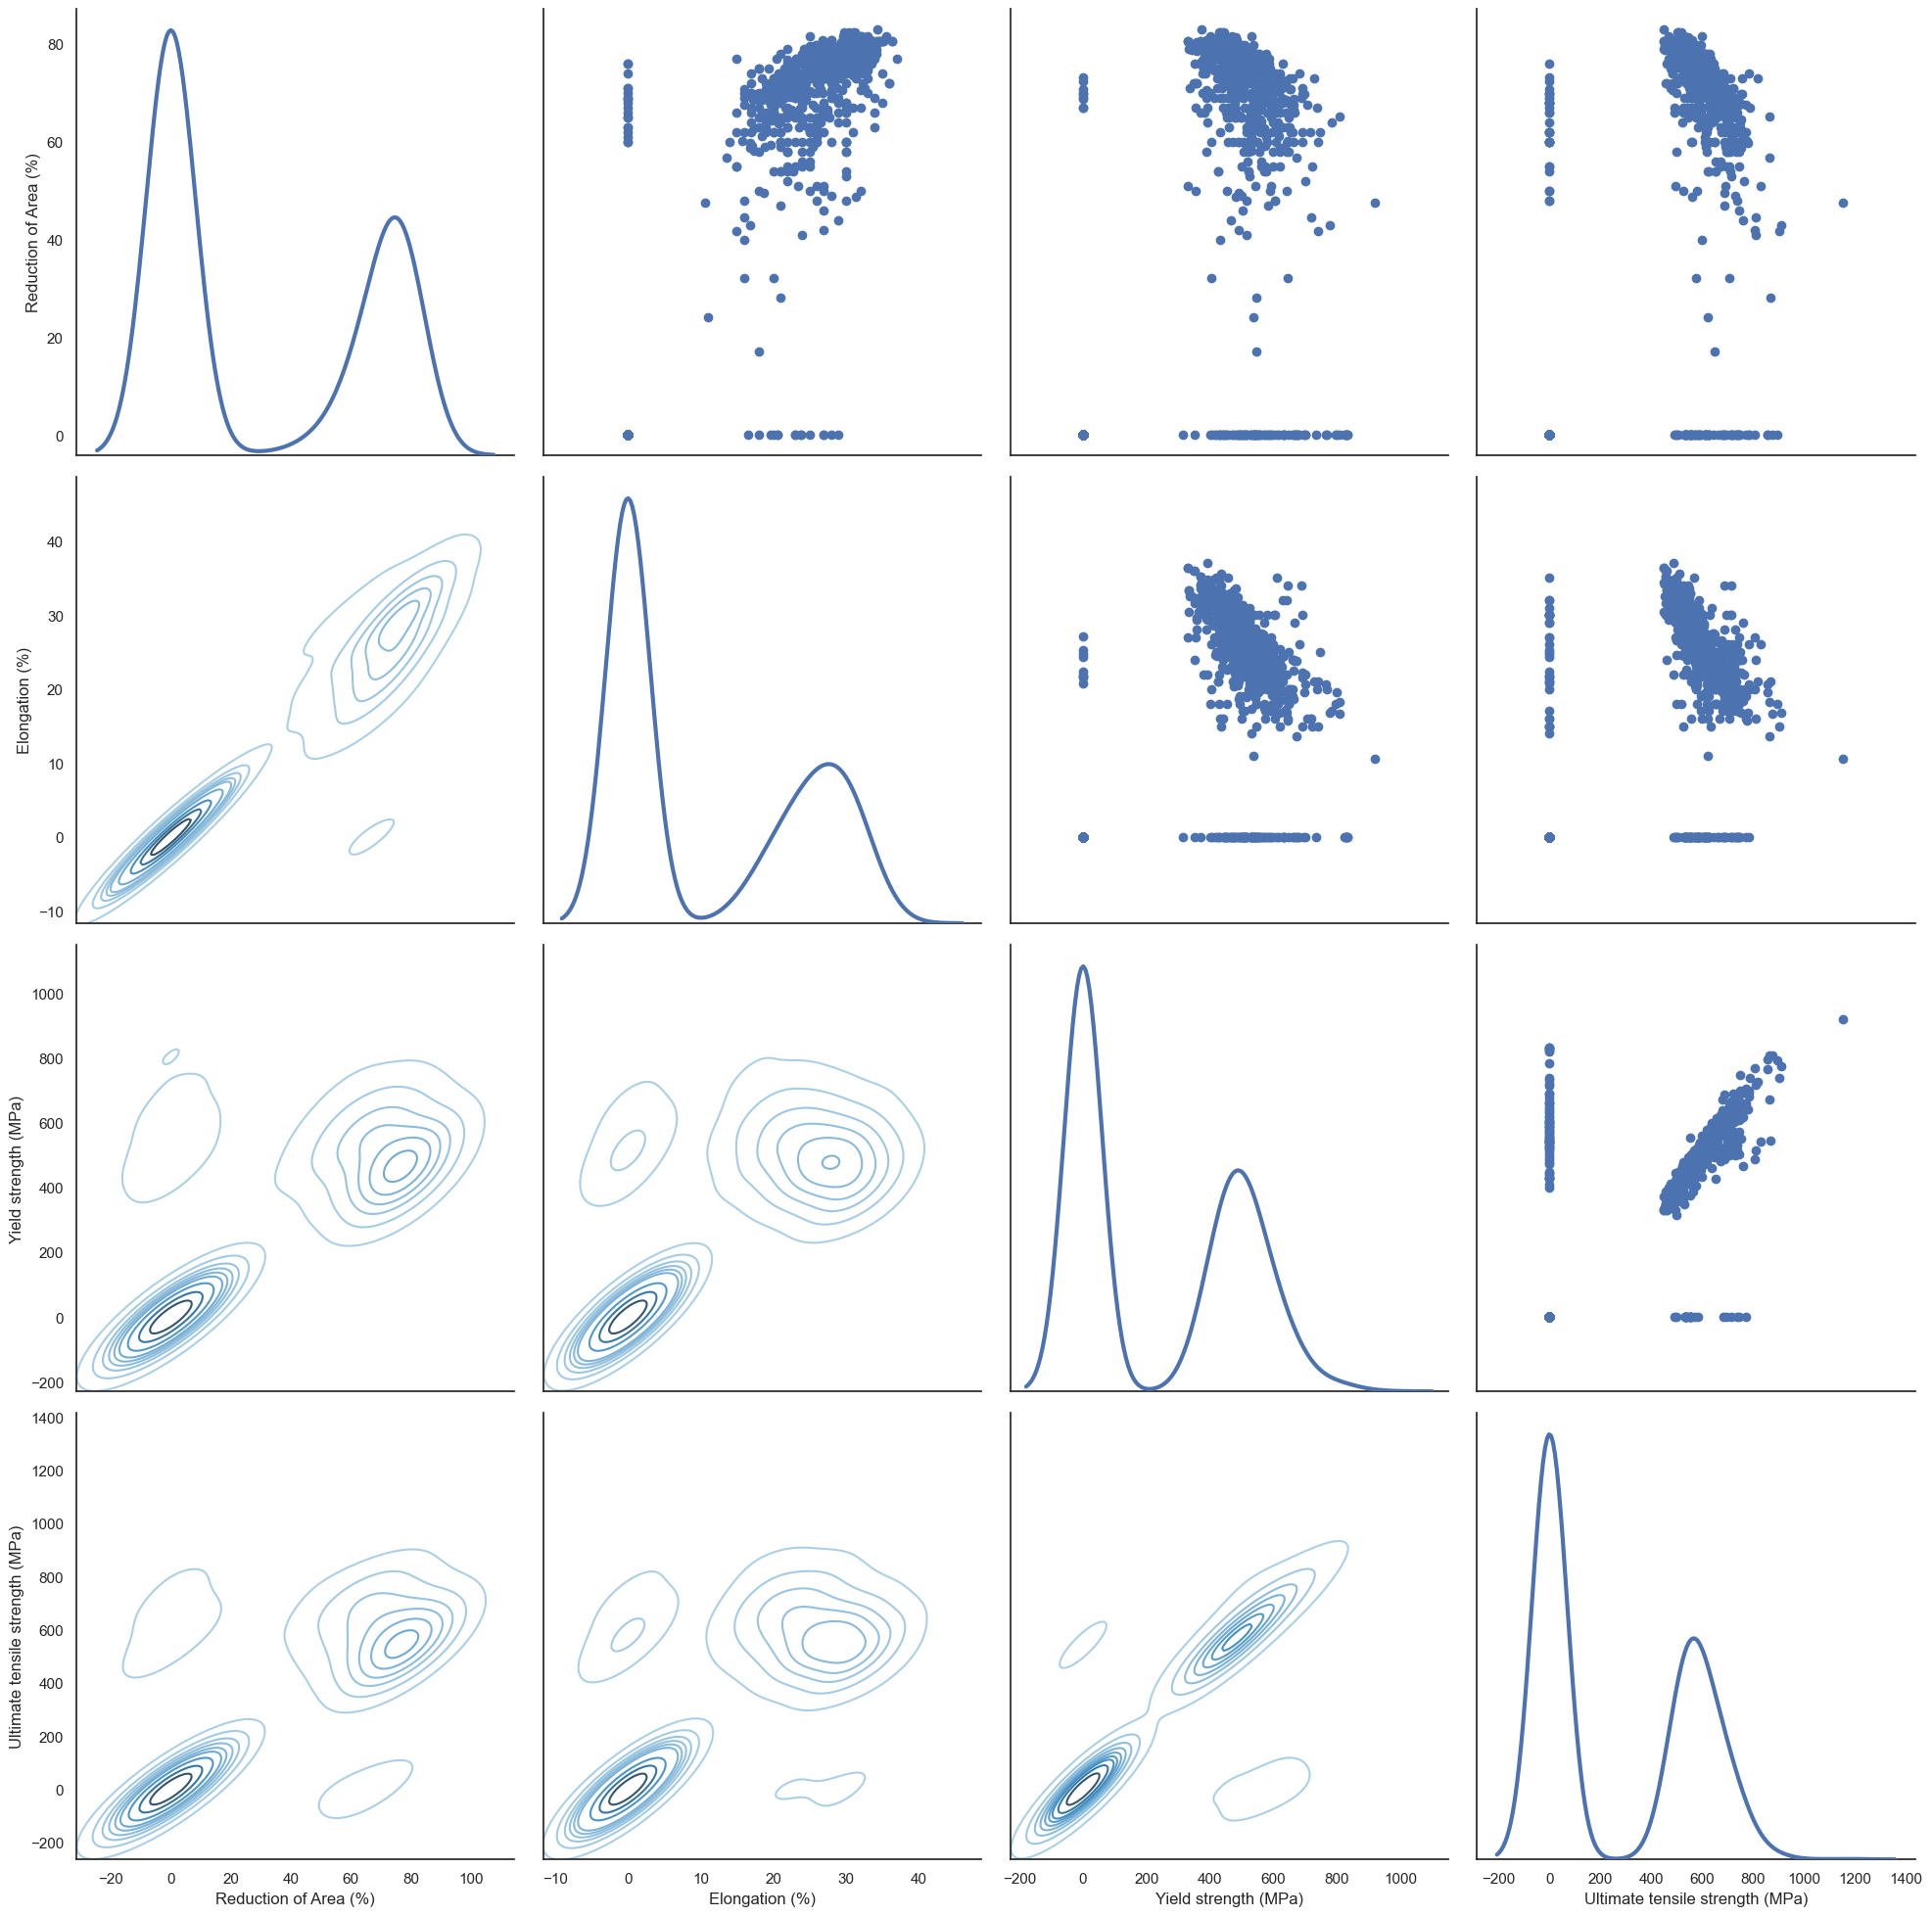

In [231]:
sns.set(style="white")
g = sns.PairGrid(data_numeric.loc[:,['Reduction of Area (%)','Elongation (%)','Yield strength (MPa)', 'Ultimate tensile strength (MPa)']], diag_sharey=False, height=5, aspect=1)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

Categoric features

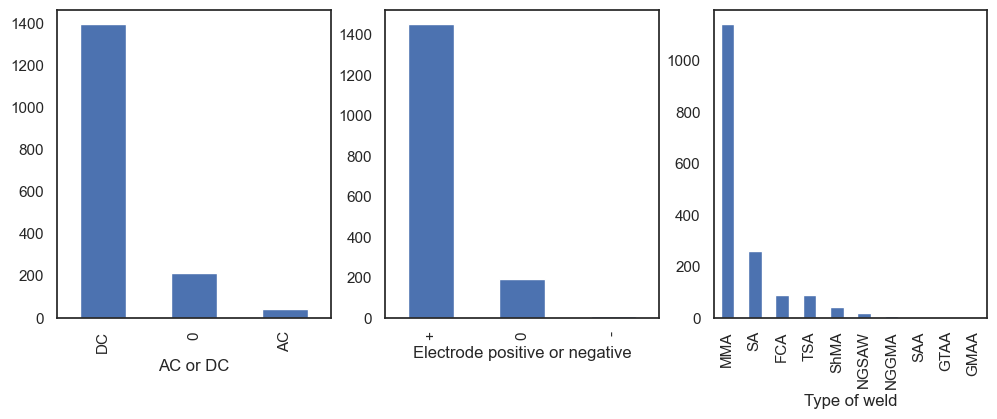

In [232]:
data_categoric["Electrode positive or negative"] = data_categoric["Electrode positive or negative"].replace([0, '0'], '0')
data_categoric["Electrode positive or negative"] = data_categoric["Electrode positive or negative"].astype("category")

fig, axs = plt.subplots(1, 3, figsize = (12,4))

for ax, col in zip(axs.flatten(), categoric_features):
    data_categoric[col].value_counts().plot(ax = ax, kind = 'bar')
    
plt.tight_layout
plt.show()

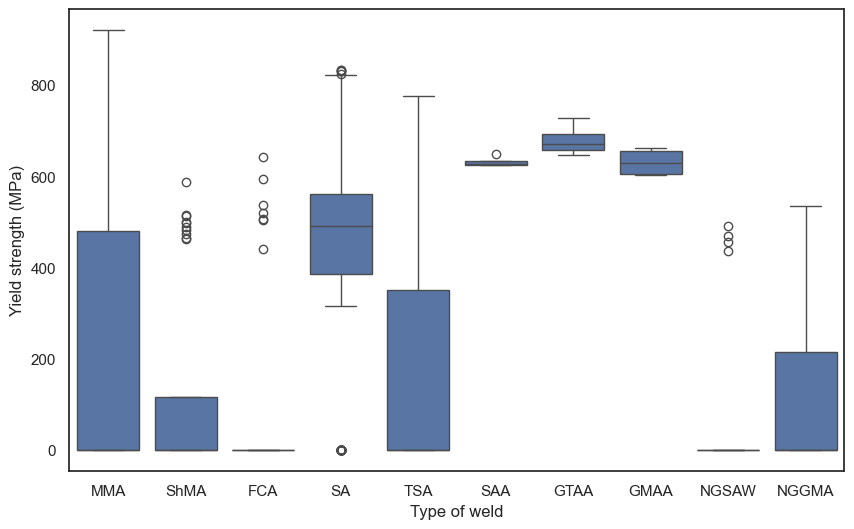

In [233]:
plt.figure(figsize=(10,6))
sns.boxplot(data = data_all, x = "Type of weld", y = "Yield strength (MPa)")
plt.show()

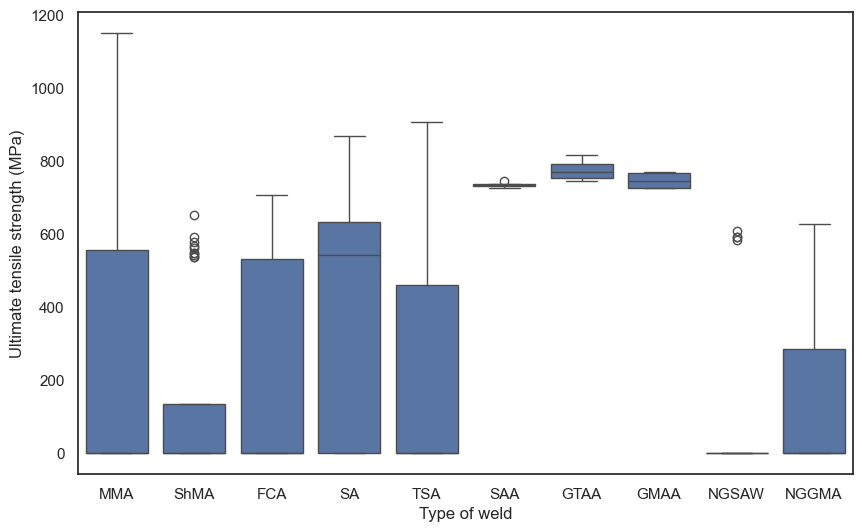

In [234]:
plt.figure(figsize=(10,6))
sns.boxplot(data = data_all, x = "Type of weld", y = "Ultimate tensile strength (MPa)")
plt.show()

# Analysis of Yield Strenght

### Modeling - Regression

Including categoric features

In [235]:
categoric_features = ['AC or DC', 'Electrode positive or negative','Type of weld'] # Weld ID isn't important
data_categoric = data[categoric_features] 

# Convert columns to numeric 
numeric_features = data.drop(columns = ['Weld ID','AC or DC', 'Electrode positive or negative','Type of weld']).columns
data_numeric = data[numeric_features].apply(pd.to_numeric, errors='coerce')

# Concatenate dataframes

df_yield_strenght = pd.concat([data_numeric, data_categoric], axis = 1)
df_yield_strenght = df_yield_strenght.drop_duplicates(keep='last')
df_yield_strenght = df_yield_strenght.drop(columns = ['Charpy temperature (°C)', '50% FATT'])

## Feature selection by the correlation matrix

X = df_yield_strenght.drop(columns = ["Yield strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"])
y = df_yield_strenght["Yield strength (MPa)"]
y.fillna(0, inplace= True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## Pre Processing 

mean_phosphorus = X_train['Phosphorus concentration (weight%)'].dropna().astype(float).mean()

# Replace NaNs with average values for Phosphorus and Sulphur
X_train['Phosphorus concentration (weight%)'] = X_train['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)
X_test['Phosphorus concentration (weight%)'] = X_test['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)

# Replace NaNs with 0 for the other columns
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Categoric features 
X_train["Electrode positive or negative"] = X_train["Electrode positive or negative"].astype("str")
X_test["Electrode positive or negative"] = X_test["Electrode positive or negative"].astype("str")

X_train['AC or DC'] = X_train['AC or DC'].astype("str")
X_test['AC or DC'] = X_test['AC or DC'].astype("str")

X_train['Type of weld'] = X_train['Type of weld'].astype("str")
X_test['Type of weld'] = X_test['Type of weld'].astype("str")

numeric_features_updated = [feature for feature in numeric_features if feature not in ["Yield strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)", 'Charpy temperature (°C)', '50% FATT']]

preprocessor = ColumnTransformer(
    transformers = [
        ("cat", OneHotEncoder(handle_unknown="ignore"), categoric_features),
    ]
)

preprocessor_scaler = ColumnTransformer(
    transformers = [
        #("num", MinMaxScaler(), numeric_features_updated),
        ("num", StandardScaler(), numeric_features_updated),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categoric_features),
    ]
)

## Linear Regression
print("\n -------------------- Linear Regression -------------------- \n")
lr_pipeline = Pipeline(
    [
        ("preprocessor_scaler", preprocessor_scaler),
        ("Regressor", LinearRegression())
    ]
)

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("MAPE LR :", mean_absolute_percentage_error(y_pred_lr, y_test))
print("R2 LR :", r2_score(y_pred_lr, y_test))
print("MSE LR :", mean_squared_error(y_pred_lr, y_test))

## Ridge Regression

print("\n -------------------- Ridge Regression -------------------- \n")
ridge_pipeline = Pipeline(
    [
        ("preprocessor_scaler", preprocessor_scaler),
        ("Regressor", Ridge())
    ]
)

ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)

print("MAPE Ridge :", mean_absolute_percentage_error(y_pred_ridge, y_test))
print("R2 Ridge :", r2_score(y_pred_ridge, y_test))
print("MSE Ridge :", mean_squared_error(y_pred_ridge, y_test))

## Lasso Regression

print("\n -------------------- Lasso Regression -------------------- \n")
lasso_pipeline = Pipeline(
    [
        ("preprocessor_scaler", preprocessor_scaler),
        ("Regressor", Lasso())
    ]
)

lasso_pipeline.fit(X_train, y_train)
y_pred_lasso = lasso_pipeline.predict(X_test)

print("MAPE Lasso :", mean_absolute_percentage_error(y_pred_lasso, y_test))
print("R2 Lasso :", r2_score(y_pred_lasso, y_test))
print("MSE Lasso :", mean_squared_error(y_pred_lasso, y_test))

## ElasticNet Regression

print("\n -------------------- ElasticNet Regression -------------------- \n")
ElasticNet_pipeline = Pipeline(
    [
        ("preprocessor_scaler", preprocessor_scaler),
        ("Regressor", ElasticNet())
    ]
)

ElasticNet_pipeline.fit(X_train, y_train)
y_pred_ElasticNet = ElasticNet_pipeline.predict(X_test)

print("MAPE ElasticNet :", mean_absolute_percentage_error(y_pred_ElasticNet, y_test))
print("R2 ElasticNet :", r2_score(y_pred_ElasticNet, y_test))
print("MSE ElasticNet :", mean_squared_error(y_pred_ElasticNet, y_test))

## Decision Tree Regression

print("\n -------------------- Decision Tree Regression -------------------- \n")
tree_pipeline = Pipeline(
    [
        ("preprocessor_scaler", preprocessor_scaler),
        ("Regressor", DecisionTreeRegressor())
    ]
)

tree_pipeline.fit(X_train, y_train)
y_pred_tree = tree_pipeline.predict(X_test)

print("MAPE Decision Tree :", mean_absolute_percentage_error(y_pred_tree, y_test))
print("R2 Decision Tree :", r2_score(y_pred_tree, y_test))
print("MSE Decision Tree :", mean_squared_error(y_pred_tree, y_test))

## Random Forest Regression

print("\n -------------------- Random Forest Regression -------------------- \n")
RF_pipeline = Pipeline(
    [
        ("preprocessor_scaler", preprocessor_scaler),
        ("Regressor", RandomForestRegressor())
    ]
)

RF_pipeline.fit(X_train, y_train)
y_pred_RF = RF_pipeline.predict(X_test)

print("MAPE RF:", mean_absolute_percentage_error(y_pred_RF, y_test))
print("R2 RF :", r2_score(y_pred_RF, y_test))
print("MSE RF :", mean_squared_error(y_pred_RF, y_test))

## Gradient Boosting Regression

print("\n -------------------- Gradient Boosting Regression -------------------- \n")
gb_pipeline = Pipeline(
    [
        ("preprocessor_scaler", preprocessor_scaler),
        ("Regressor", GradientBoostingRegressor())
    ]
)

gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)

print("MAPE Gradient Boosting:", mean_absolute_percentage_error(y_pred_gb, y_test))
print("R2 Gradient Boosting :", r2_score(y_pred_gb, y_test))
print("MSE Gradient Boosting :", mean_squared_error(y_pred_gb, y_test))


 -------------------- Linear Regression -------------------- 

MAPE LR : 0.6567489379970285
R2 LR : 0.780071057196552
MSE LR : 12553.424893564894

 -------------------- Ridge Regression -------------------- 

MAPE Ridge : 0.6544242173866552
R2 Ridge : 0.7805432907234002
MSE Ridge : 12484.574086950126

 -------------------- Lasso Regression -------------------- 

MAPE Lasso : 0.654710725282012
R2 Lasso : 0.7770843211228546
MSE Lasso : 12411.153470961965

 -------------------- ElasticNet Regression -------------------- 

MAPE ElasticNet : 0.6781907852012847
R2 ElasticNet : 0.5563475595734695
MSE ElasticNet : 16257.96644697531

 -------------------- Decision Tree Regression -------------------- 

MAPE Decision Tree : 2.2608979947506428e+16
R2 Decision Tree : 0.9171352317909791
MSE Decision Tree : 5794.284505050505

 -------------------- Random Forest Regression -------------------- 

MAPE RF: 0.06888518624062351
R2 RF : 0.9798261595852678
MSE RF : 1379.2570279010101

 -------------------

excluding categorical features

In [236]:
def metrics_pipelines(X_train, X_test, y_train, y_test):
    
    ## Linear Regression
    print("\n -------------------- Linear Regression -------------------- \n")
    lr_pipeline = Pipeline(
        [
            ("scaler", MinMaxScaler()),
            ("Regressor", LinearRegression())
        ]
    )

    lr_pipeline.fit(X_train, y_train)
    y_pred_lr = lr_pipeline.predict(X_test)

    print("MAPE LR :", mean_absolute_percentage_error(y_pred_lr, y_test))
    print("R2 LR :", r2_score(y_pred_lr, y_test))
    print("MSE LR :", mean_squared_error(y_pred_lr, y_test))

    ## Ridge Regression

    print("\n -------------------- Ridge Regression -------------------- \n")
    ridge_pipeline = Pipeline(
        [
            ("scaler", MinMaxScaler()),
            ("Regressor", Ridge())
        ]
    )

    ridge_pipeline.fit(X_train, y_train)
    y_pred_ridge = ridge_pipeline.predict(X_test)

    print("MAPE Ridge :", mean_absolute_percentage_error(y_pred_ridge, y_test))
    print("R2 Ridge :", r2_score(y_pred_ridge, y_test))
    print("MSE Ridge :", mean_squared_error(y_pred_ridge, y_test))

    ## Lasso Regression

    print("\n -------------------- Lasso Regression -------------------- \n")
    lasso_pipeline = Pipeline(
        [
            ("scaler", MinMaxScaler()),
            ("Regressor", Lasso())
        ]
    )

    lasso_pipeline.fit(X_train, y_train)
    y_pred_lasso = lasso_pipeline.predict(X_test)

    print("MAPE Lasso :", mean_absolute_percentage_error(y_pred_lasso, y_test))
    print("R2 Lasso :", r2_score(y_pred_lasso, y_test))
    print("MSE Lasso :", mean_squared_error(y_pred_lasso, y_test))

    ## ElasticNet Regression

    print("\n -------------------- ElasticNet Regression -------------------- \n")
    ElasticNet_pipeline = Pipeline(
        [
            ("scaler", StandardScaler()), # StandardScaler is better than MinMaxScaler for this model
            ("Regressor", ElasticNet())
        ]
    )

    ElasticNet_pipeline.fit(X_train, y_train)
    y_pred_ElasticNet = ElasticNet_pipeline.predict(X_test)

    print("MAPE ElasticNet :", mean_absolute_percentage_error(y_pred_ElasticNet, y_test))
    print("R2 ElasticNet :", r2_score(y_pred_ElasticNet, y_test))
    print("MSE ElasticNet :", mean_squared_error(y_pred_ElasticNet, y_test))

    ## Decision Tree Regression

    print("\n -------------------- Decision Tree Regression -------------------- \n")
    tree_pipeline = Pipeline(
        [
            ("Regressor", DecisionTreeRegressor(random_state= 42))
        ]
    )

    tree_pipeline.fit(X_train, y_train)
    y_pred_tree = tree_pipeline.predict(X_test)

    print("MAPE Decision Tree :", mean_absolute_percentage_error(y_pred_tree, y_test))
    print("R2 Decision Tree :", r2_score(y_pred_tree, y_test))
    print("MSE Decision Tree :", mean_squared_error(y_pred_tree, y_test))

    ## Random Forest Regression

    print("\n -------------------- Random Forest Regression -------------------- \n")
    RF_pipeline = Pipeline(
        [
            ("Regressor", RandomForestRegressor(random_state= 42))
        ]
    )

    RF_pipeline.fit(X_train, y_train)
    y_pred_RF = RF_pipeline.predict(X_test)

    print("MAPE RF:", mean_absolute_percentage_error(y_pred_RF, y_test))
    print("R2 RF :", r2_score(y_pred_RF, y_test))
    print("MSE RF :", mean_squared_error(y_pred_RF, y_test))

    ## Gradient Boosting Regression

    print("\n -------------------- Gradient Boosting Regression -------------------- \n")
    gb_pipeline = Pipeline(
        [
            ("Regressor", GradientBoostingRegressor(random_state= 42))
        ]
    )

    gb_pipeline.fit(X_train, y_train)
    y_pred_gb = gb_pipeline.predict(X_test)

    print("MAPE Gradient Boosting:", mean_absolute_percentage_error(y_pred_gb, y_test))
    print("R2 Gradient Boosting :", r2_score(y_pred_gb, y_test))
    print("MSE Gradient Boosting :", mean_squared_error(y_pred_gb, y_test))
        

In [237]:
# Convert columns to numeric 
numeric_features = data.drop(columns = ['Weld ID','AC or DC', 'Electrode positive or negative','Type of weld']).columns
df_yield_strenght = data[numeric_features].apply(pd.to_numeric, errors='coerce')

df_yield_strenght = df_yield_strenght.drop_duplicates(keep='last')
df_yield_strenght = df_yield_strenght.drop(columns = ['Charpy temperature (°C)', '50% FATT'])

## Split the data into train and test
X = df_yield_strenght.drop(columns = ["Yield strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"])
y = df_yield_strenght["Yield strength (MPa)"]
y.fillna(0, inplace= True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## Pre Processing 

mean_phosphorus = X_train['Phosphorus concentration (weight%)'].dropna().astype(float).mean()

# Replace NaNs with average values for Phosphorus and Sulphur
X_train['Phosphorus concentration (weight%)'] = X_train['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)
X_test['Phosphorus concentration (weight%)'] = X_test['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)

# Replace NaNs with 0 for the other columns
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

metrics_pipelines(X_train, X_test, y_train, y_test)


 -------------------- Linear Regression -------------------- 

MAPE LR : 0.6508242123036657
R2 LR : 0.7745337875012176
MSE LR : 12623.160993082365

 -------------------- Ridge Regression -------------------- 

MAPE Ridge : 0.6535757980368876
R2 Ridge : 0.7681059793260117
MSE Ridge : 12745.660294267082

 -------------------- Lasso Regression -------------------- 

MAPE Lasso : 0.6943110982106449
R2 Lasso : 0.7378098124055594
MSE Lasso : 13780.41898872496

 -------------------- ElasticNet Regression -------------------- 

MAPE ElasticNet : 0.6809567065381881
R2 ElasticNet : 0.5459839979420066
MSE ElasticNet : 16521.345756005914

 -------------------- Decision Tree Regression -------------------- 

MAPE Decision Tree : 0.024119511500644935
R2 Decision Tree : 0.9803967023937956
MSE Decision Tree : 1424.1880202020204

 -------------------- Random Forest Regression -------------------- 

MAPE RF: 0.07163648717080875
R2 RF : 0.9765852151527729
MSE RF : 1596.217907492929

 -------------------

### Feature Selection

Select K-best

In [238]:
# Convert columns to numeric 
numeric_features = data.drop(columns = ['Weld ID','AC or DC', 'Electrode positive or negative','Type of weld']).columns
df_yield_strenght = data[numeric_features].apply(pd.to_numeric, errors='coerce')

df_yield_strenght = df_yield_strenght.drop_duplicates(keep='last')
df_yield_strenght = df_yield_strenght.drop(columns = ['Charpy temperature (°C)', '50% FATT'])

X = df_yield_strenght.drop(columns = ["Yield strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"])
y = df_yield_strenght["Yield strength (MPa)"]
y.fillna(0, inplace= True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## Pre Processing 

mean_phosphorus = X_train['Phosphorus concentration (weight%)'].dropna().astype(float).mean()

# Replace NaNs with average values for Phosphorus and Sulphur
X_train['Phosphorus concentration (weight%)'] = X_train['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)
X_test['Phosphorus concentration (weight%)'] = X_test['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)

# Replace NaNs with 0 for the other columns
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Univariate method
select_features = SelectKBest(f_regression, k = 10).fit(X_train, y_train)

X_train_selected = select_features.transform(X_train)
X_test_selected = select_features.transform(X_test)

metrics_pipelines(X_train_selected, X_test_selected, y_train, y_test)


 -------------------- Linear Regression -------------------- 

MAPE LR : 0.6919802814958844
R2 LR : 0.7279123085487249
MSE LR : 14898.07632578228

 -------------------- Ridge Regression -------------------- 

MAPE Ridge : 0.6928037783540958
R2 Ridge : 0.7238109273117685
MSE Ridge : 14929.953893770078

 -------------------- Lasso Regression -------------------- 

MAPE Lasso : 0.7170980770873802
R2 Lasso : 0.7125213096897811
MSE Lasso : 15026.554482309164

 -------------------- ElasticNet Regression -------------------- 

MAPE ElasticNet : 0.6974957594657546
R2 ElasticNet : 0.5029954581829187
MSE ElasticNet : 17892.39836795727

 -------------------- Decision Tree Regression -------------------- 

MAPE Decision Tree : 8843431995563883.0
R2 Decision Tree : 0.9687060205385435
MSE Decision Tree : 2151.467274971941

 -------------------- Random Forest Regression -------------------- 

MAPE RF: 0.05300681126275602
R2 RF : 0.9773686709334177
MSE RF : 1525.2881693439751

 -------------------- G

RFECV

In [239]:
# Convert columns to numeric 
numeric_features = data.drop(columns = ['Weld ID','AC or DC', 'Electrode positive or negative','Type of weld']).columns
df_yield_strenght = data[numeric_features].apply(pd.to_numeric, errors='coerce')

df_yield_strenght = df_yield_strenght.drop_duplicates(keep='last')
df_yield_strenght = df_yield_strenght.drop(columns = ['Charpy temperature (°C)', '50% FATT'])

X = df_yield_strenght.drop(columns = ["Yield strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"])
y = df_yield_strenght["Yield strength (MPa)"]
y.fillna(0, inplace= True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## Pre Processing 

mean_phosphorus = X_train['Phosphorus concentration (weight%)'].dropna().astype(float).mean()

# Replace NaNs with average values for Phosphorus and Sulphur
X_train['Phosphorus concentration (weight%)'] = X_train['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)
X_test['Phosphorus concentration (weight%)'] = X_test['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)

# Replace NaNs with 0 for the other columns
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Univariate method

rfecv = RFECV(estimator=RandomForestRegressor(), step=1, cv = 5, scoring="r2") # 5 - fold cross validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 6
Best features : Index(['Vanadium concentration (weight%)',
       'Antimony concentration (ppm by weight)', 'Current (A)',
       'Ultimate tensile strength (MPa)', 'Reduction of Area (%)',
       'Charpy impact toughness (J)'],
      dtype='object')


In [250]:
## Split the data into train and test

# Convert columns to numeric 
numeric_features = data.drop(columns = ['Weld ID','AC or DC', 'Electrode positive or negative','Type of weld']).columns
df_yield_strenght = data[numeric_features].apply(pd.to_numeric, errors='coerce')

df_yield_strenght = df_yield_strenght.drop_duplicates(keep='last')
df_yield_strenght = df_yield_strenght.drop(columns = ['Charpy temperature (°C)', '50% FATT'])

X = df_yield_strenght[[
    'Vanadium concentration (weight%)',
    'Antimony concentration (ppm by weight)', 'Current (A)',
    'Ultimate tensile strength (MPa)', 'Reduction of Area (%)',
    'Charpy impact toughness (J)']]

y = df_yield_strenght["Yield strength (MPa)"]

y.fillna(0, inplace= True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## Pre Processing 

if 'Phosphorus concentration (weight%)' in X_train.columns:
    mean_phosphorus = X_train['Phosphorus concentration (weight%)'].dropna().astype(float).mean()

    # Replace NaNs with average values for Phosphorus and Sulphur
    X_train['Phosphorus concentration (weight%)'] = X_train['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)
    X_test['Phosphorus concentration (weight%)'] = X_test['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)

# Replace NaNs with 0 for the other columns
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

metrics_pipelines(X_train, X_test, y_train, y_test)


 -------------------- Linear Regression -------------------- 

MAPE LR : 0.7282308150747354
R2 LR : 0.7102597890234077
MSE LR : 15416.91241403818

 -------------------- Ridge Regression -------------------- 

MAPE Ridge : 0.7267532610198305
R2 Ridge : 0.7063029461342527
MSE Ridge : 15417.722819495006

 -------------------- Lasso Regression -------------------- 

MAPE Lasso : 0.7282814927997437
R2 Lasso : 0.7002108946378889
MSE Lasso : 15251.161122630005

 -------------------- ElasticNet Regression -------------------- 

MAPE ElasticNet : 0.7127887162252958
R2 ElasticNet : 0.4572274523369596
MSE ElasticNet : 18553.203072133245

 -------------------- Decision Tree Regression -------------------- 

MAPE Decision Tree : 0.027869058912394787
R2 Decision Tree : 0.9734553389649517
MSE Decision Tree : 1885.165820426487

 -------------------- Random Forest Regression -------------------- 

MAPE RF: 0.048271717553395814
R2 RF : 0.9850057147795236
MSE RF : 1052.1275534762724

 ------------------

Tree based feature selection

Feature ranking:
1. feature 24 (0.436144)
2. feature 25 (0.355882)
3. feature 18 (0.089686)
4. feature 5 (0.025437)
5. feature 26 (0.022183)
6. feature 17 (0.018185)
7. feature 13 (0.013156)
8. feature 14 (0.007686)
9. feature 9 (0.004164)
10. feature 3 (0.003948)
11. feature 16 (0.002880)
12. feature 2 (0.002780)
13. feature 22 (0.002446)
14. feature 20 (0.002001)
15. feature 23 (0.001911)
16. feature 11 (0.001866)
17. feature 0 (0.001397)
18. feature 1 (0.001224)
19. feature 19 (0.001179)
20. feature 6 (0.001135)
21. feature 21 (0.001012)
22. feature 4 (0.000905)
23. feature 12 (0.000700)
24. feature 10 (0.000543)
25. feature 15 (0.000430)
26. feature 7 (0.000310)
27. feature 29 (0.000302)
28. feature 30 (0.000214)
29. feature 27 (0.000131)
30. feature 28 (0.000124)
31. feature 8 (0.000040)
32. feature 31 (0.000000)
33. feature 32 (0.000000)


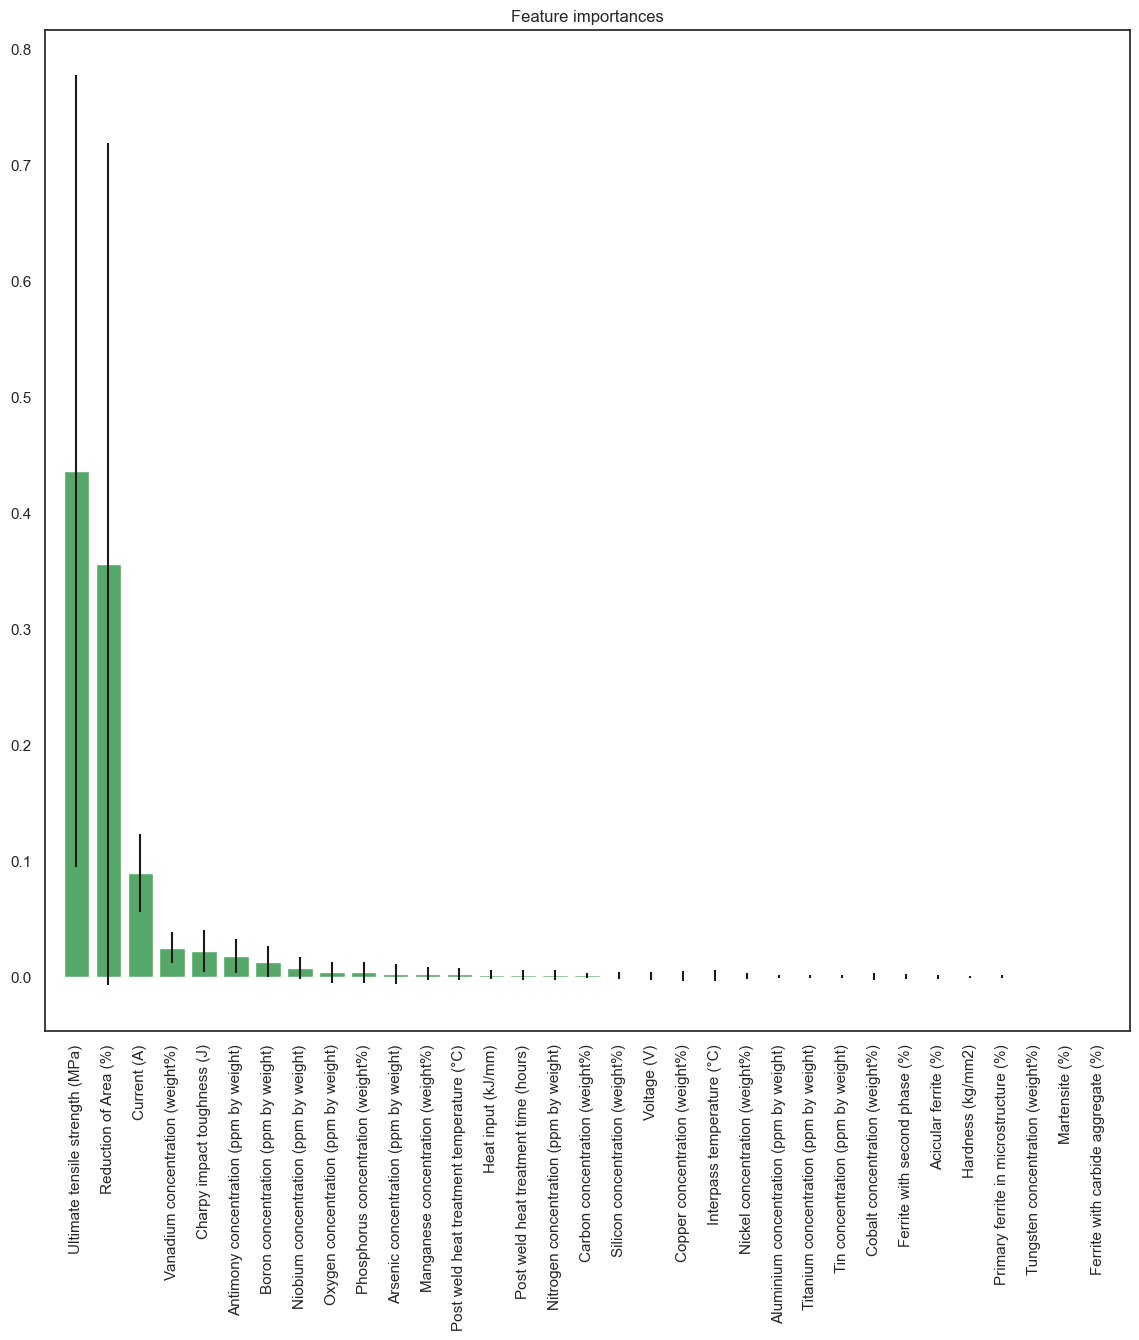

In [241]:
# Convert columns to numeric 
numeric_features = data.drop(columns = ['Weld ID','AC or DC', 'Electrode positive or negative','Type of weld']).columns
df_yield_strenght = data[numeric_features].apply(pd.to_numeric, errors='coerce')

df_yield_strenght = df_yield_strenght.drop_duplicates(keep='last')
df_yield_strenght = df_yield_strenght.drop(columns = ['Charpy temperature (°C)', '50% FATT'])

X = df_yield_strenght.drop(columns = ["Yield strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"])
y = df_yield_strenght["Yield strength (MPa)"]
y.fillna(0, inplace= True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## Pre Processing 

if 'Phosphorus concentration (weight%)' in X_train.columns:
    mean_phosphorus = X_train['Phosphorus concentration (weight%)'].dropna().astype(float).mean()

    # Replace NaNs with average values for Phosphorus and Sulphur
    X_train['Phosphorus concentration (weight%)'] = X_train['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)
    X_test['Phosphorus concentration (weight%)'] = X_test['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)

# Replace NaNs with 0 for the other columns
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Tree based feature selection

regressor_test = RandomForestRegressor().fit(X_train, y_train)
importances = regressor_test.feature_importances_

std = np.std([tree.feature_importances_ for tree in regressor_test.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Analysis of the Ultimate Tensile Strength

### Modeling - Regression

In [242]:
# Convert columns to numeric 
numeric_features = data.drop(columns = ['Weld ID','AC or DC', 'Electrode positive or negative','Type of weld']).columns
df_uts = data[numeric_features].apply(pd.to_numeric, errors='coerce')

df_uts = df_uts.drop_duplicates(keep='last')
df_uts = df_uts.drop(columns = ['Charpy temperature (°C)', '50% FATT'])

X = df_uts.drop(columns = ["Ultimate tensile strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"])
y = df_uts["Ultimate tensile strength (MPa)"]
y.fillna(0, inplace= True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## Pre Processing 

mean_phosphorus = X_train['Phosphorus concentration (weight%)'].dropna().astype(float).mean()

# Replace NaNs with average values for Phosphorus and Sulphur
X_train['Phosphorus concentration (weight%)'] = X_train['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)
X_test['Phosphorus concentration (weight%)'] = X_test['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)

# Replace NaNs with 0 for the other columns
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

metrics_pipelines(X_train, X_test, y_train, y_test)


 -------------------- Linear Regression -------------------- 

MAPE LR : 0.7646552098239346
R2 LR : 0.7565854652871629
MSE LR : 18283.74192011596

 -------------------- Ridge Regression -------------------- 

MAPE Ridge : 0.8330005930957477
R2 Ridge : 0.7495192472931395
MSE Ridge : 18562.942618604193

 -------------------- Lasso Regression -------------------- 

MAPE Lasso : 0.7203415783330022
R2 Lasso : 0.7239753730790967
MSE Lasso : 20027.598034466257

 -------------------- ElasticNet Regression -------------------- 

MAPE ElasticNet : 0.6933815117615858
R2 ElasticNet : 0.5038984709979394
MSE ElasticNet : 23511.570845328442

 -------------------- Decision Tree Regression -------------------- 

MAPE Decision Tree : 0.019098020919728557
R2 Decision Tree : 0.9621220569400948
MSE Decision Tree : 3551.5995757575756

 -------------------- Random Forest Regression -------------------- 

MAPE RF: 0.0987657475866327
R2 RF : 0.9676650672428162
MSE RF : 2763.564966636363

 --------------------

### Feature Selection

Select K-best

In [243]:
# Convert columns to numeric 
numeric_features = data.drop(columns = ['Weld ID','AC or DC', 'Electrode positive or negative','Type of weld']).columns
df_uts = data[numeric_features].apply(pd.to_numeric, errors='coerce')

df_uts = df_uts.drop_duplicates(keep='last')
df_uts = df_uts.drop(columns = ['Charpy temperature (°C)', '50% FATT'])

X = df_uts.drop(columns = ["Ultimate tensile strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"])
y = df_uts["Ultimate tensile strength (MPa)"]
y.fillna(0, inplace= True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## Pre Processing 

mean_phosphorus = X_train['Phosphorus concentration (weight%)'].dropna().astype(float).mean()

# Replace NaNs with average values for Phosphorus and Sulphur
X_train['Phosphorus concentration (weight%)'] = X_train['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)
X_test['Phosphorus concentration (weight%)'] = X_test['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)

# Replace NaNs with 0 for the other columns
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Univariate method
select_features = SelectKBest(f_regression, k = 10).fit(X_train, y_train)

X_train_selected = select_features.transform(X_train)
X_test_selected = select_features.transform(X_test)

metrics_pipelines(X_train, X_test, y_train, y_test)


 -------------------- Linear Regression -------------------- 

MAPE LR : 0.7646552098239346
R2 LR : 0.7565854652871629
MSE LR : 18283.74192011596

 -------------------- Ridge Regression -------------------- 

MAPE Ridge : 0.8330005930957477
R2 Ridge : 0.7495192472931395
MSE Ridge : 18562.942618604193

 -------------------- Lasso Regression -------------------- 

MAPE Lasso : 0.7203415783330022
R2 Lasso : 0.7239753730790967
MSE Lasso : 20027.598034466257

 -------------------- ElasticNet Regression -------------------- 

MAPE ElasticNet : 0.6933815117615858
R2 ElasticNet : 0.5038984709979394
MSE ElasticNet : 23511.570845328442

 -------------------- Decision Tree Regression -------------------- 

MAPE Decision Tree : 0.019098020919728557
R2 Decision Tree : 0.9621220569400948
MSE Decision Tree : 3551.5995757575756

 -------------------- Random Forest Regression -------------------- 

MAPE RF: 0.0987657475866327
R2 RF : 0.9676650672428162
MSE RF : 2763.564966636363

 --------------------

RFECV

In [244]:
# Convert columns to numeric 
numeric_features = data.drop(columns = ['Weld ID','AC or DC', 'Electrode positive or negative','Type of weld']).columns
df_uts = data[numeric_features].apply(pd.to_numeric, errors='coerce')

df_uts = df_uts.drop_duplicates(keep='last')
df_uts = df_uts.drop(columns = ['Charpy temperature (°C)', '50% FATT'])

X = df_uts.drop(columns = ["Ultimate tensile strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"])
y = df_uts["Ultimate tensile strength (MPa)"]
y.fillna(0, inplace= True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## Pre Processing 

mean_phosphorus = X_train['Phosphorus concentration (weight%)'].dropna().astype(float).mean()

# Replace NaNs with average values for Phosphorus and Sulphur
X_train['Phosphorus concentration (weight%)'] = X_train['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)
X_test['Phosphorus concentration (weight%)'] = X_test['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)

# Replace NaNs with 0 for the other columns
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Univariate method

rfecv = RFECV(estimator=RandomForestRegressor(), step=1, cv = 5, scoring="r2") # 5 - fold cross validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 16
Best features : Index(['Silicon concentration (weight%)', 'Phosphorus concentration (weight%)',
       'Vanadium concentration (weight%)',
       'Titanium concentration (ppm by weight)',
       'Nitrogen concentration (ppm by weight)',
       'Boron concentration (ppm by weight)',
       'Tin concentration (ppm by weight)', 'Current (A)', 'Voltage (V)',
       'Heat input (kJ/mm)', 'Interpass temperature (°C)',
       'Post weld heat treatment temperature (°C)',
       'Post weld heat treatment time (hours)', 'Yield strength (MPa)',
       'Reduction of Area (%)', 'Charpy impact toughness (J)'],
      dtype='object')


In [249]:
# Convert columns to numeric 
numeric_features = data.drop(columns = ['Weld ID','AC or DC', 'Electrode positive or negative','Type of weld']).columns
df_uts = data[numeric_features].apply(pd.to_numeric, errors='coerce')

df_uts = df_uts.drop_duplicates(keep='last')
df_uts = df_uts.drop(columns = ['Charpy temperature (°C)', '50% FATT'])

X = df_uts[
    ['Silicon concentration (weight%)', 'Phosphorus concentration (weight%)',
    'Vanadium concentration (weight%)',
    'Titanium concentration (ppm by weight)',
    'Nitrogen concentration (ppm by weight)',
    'Boron concentration (ppm by weight)',
    'Tin concentration (ppm by weight)', 'Current (A)', 'Voltage (V)',
    'Heat input (kJ/mm)', 'Interpass temperature (°C)',
    'Post weld heat treatment temperature (°C)',
    'Post weld heat treatment time (hours)', 'Yield strength (MPa)',
    'Reduction of Area (%)', 'Charpy impact toughness (J)']]

y = df_uts["Ultimate tensile strength (MPa)"]
y.fillna(0, inplace= True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## Pre Processing 

mean_phosphorus = X_train['Phosphorus concentration (weight%)'].dropna().astype(float).mean()

# Replace NaNs with average values for Phosphorus and Sulphur
X_train['Phosphorus concentration (weight%)'] = X_train['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)
X_test['Phosphorus concentration (weight%)'] = X_test['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)

# Replace NaNs with 0 for the other columns
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

metrics_pipelines(X_train, X_test, y_train, y_test)


 -------------------- Linear Regression -------------------- 

MAPE LR : 0.7530975270953706
R2 LR : 0.7435577744118189
MSE LR : 19064.007306190226

 -------------------- Ridge Regression -------------------- 

MAPE Ridge : 0.8208567473751086
R2 Ridge : 0.7387985523599916
MSE Ridge : 19194.889211926737

 -------------------- Lasso Regression -------------------- 

MAPE Lasso : 0.7152475397340843
R2 Lasso : 0.718565745169577
MSE Lasso : 20319.128258236015

 -------------------- ElasticNet Regression -------------------- 

MAPE ElasticNet : 0.6952296880206033
R2 ElasticNet : 0.49070353976993686
MSE ElasticNet : 23874.10672985022

 -------------------- Decision Tree Regression -------------------- 

MAPE Decision Tree : 0.016778074539897485
R2 Decision Tree : 0.9835986854588149
MSE Decision Tree : 1508.3646060606063

 -------------------- Random Forest Regression -------------------- 

MAPE RF: 0.10331002120099637
R2 RF : 0.9709538291462514
MSE RF : 2506.8536719818185

 ------------------

Feature ranking:
1. feature 24 (0.681972)
2. feature 25 (0.136691)
3. feature 15 (0.029632)
4. feature 10 (0.017239)
5. feature 21 (0.015507)
6. feature 13 (0.012732)
7. feature 22 (0.012667)
8. feature 26 (0.010121)
9. feature 23 (0.009339)
10. feature 5 (0.009064)
11. feature 1 (0.008486)
12. feature 11 (0.008033)
13. feature 3 (0.007876)
14. feature 6 (0.007215)
15. feature 20 (0.006660)
16. feature 18 (0.006647)
17. feature 19 (0.004277)
18. feature 14 (0.002775)
19. feature 12 (0.002491)
20. feature 27 (0.002410)
21. feature 4 (0.002359)
22. feature 2 (0.002215)
23. feature 0 (0.002071)
24. feature 9 (0.000893)
25. feature 17 (0.000402)
26. feature 16 (0.000219)
27. feature 7 (0.000007)
28. feature 8 (0.000000)
29. feature 31 (0.000000)
30. feature 28 (0.000000)
31. feature 29 (0.000000)
32. feature 30 (0.000000)
33. feature 32 (0.000000)


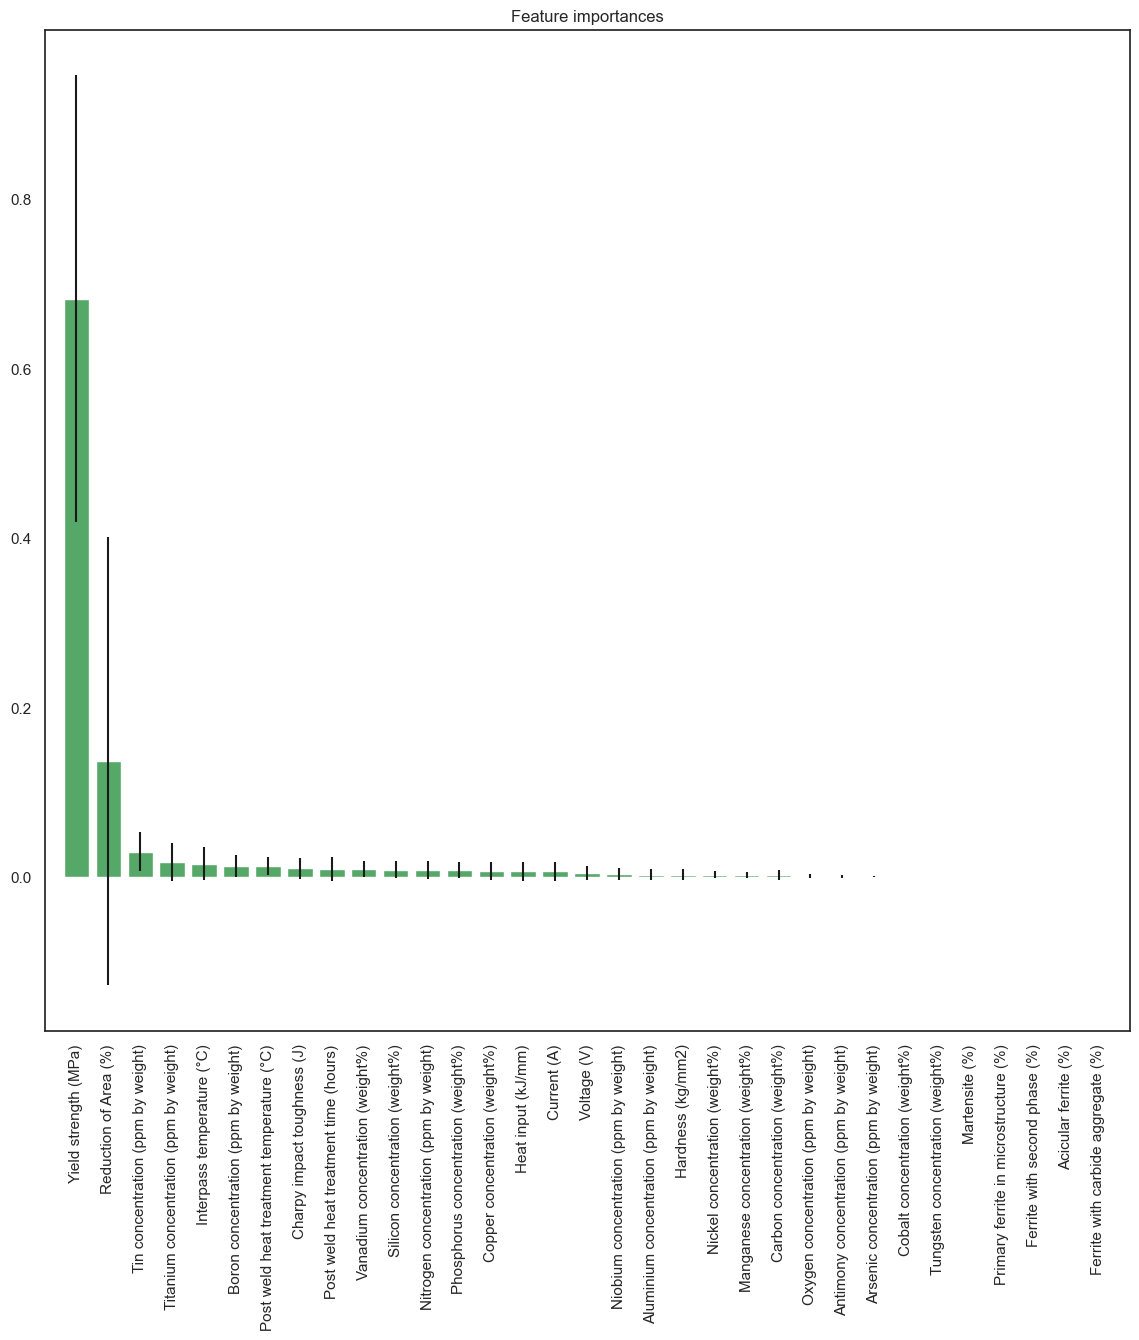

In [246]:
# Convert columns to numeric 
numeric_features = data.drop(columns = ['Weld ID','AC or DC', 'Electrode positive or negative','Type of weld']).columns
df_uts = data[numeric_features].apply(pd.to_numeric, errors='coerce')

df_uts = df_uts.drop_duplicates(keep='last')
df_uts = df_uts.drop(columns = ['Charpy temperature (°C)', '50% FATT'])

X = df_uts.drop(columns = ["Ultimate tensile strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"])
y = df_uts["Ultimate tensile strength (MPa)"]
y.fillna(0, inplace= True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## Pre Processing 

mean_phosphorus = X_train['Phosphorus concentration (weight%)'].dropna().astype(float).mean()

# Replace NaNs with average values for Phosphorus and Sulphur
X_train['Phosphorus concentration (weight%)'] = X_train['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)
X_test['Phosphorus concentration (weight%)'] = X_test['Phosphorus concentration (weight%)'].fillna(mean_phosphorus)

# Replace NaNs with 0 for the other columns
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


regressor_test = RandomForestRegressor().fit(X_train, y_train)
importances = regressor_test.feature_importances_

std = np.std([tree.feature_importances_ for tree in regressor_test.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()